In [1]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
import random

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
#from mlxtend.plotting import plot_decision_regions
from gpolnel.utils.tree import Tree
from gpolnel.problems.inductive_programming import SML
#from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, _get_tree_depth
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm, GSGP
from gpolnel.operators.initializers import grow
from gpolnel.problems.problem import Problem
from gpolnel.operators.selectors import prm_tournament
from gpolnel.operators.variators import prm_efficient_gs_mtn
import codecs
import neat

#from gpolnel.operators.variators import prm_efficient_gs_mtn
#from gpolnel.operators.selectors import prm_tournament

In [2]:
data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

In [3]:
data.head()

lactation  delivery_age_years  dim  dry_days  forage_kg_day  \
0          7            7.750000  414      56.0       4.310918   
1          8            9.083333  357      78.0       4.167087   
2          6            7.666667  315      69.0       4.903333   
3          7            8.666667  362      69.0       4.294724   
4          5            6.500000  427      58.0       4.798618   

   rumination_min_day  milk_kg_day  milk_kg_min_robot  milkings_day  \
0          434.814010    34.082367           3.695699      2.478261   
1          589.500000    36.170868           4.024165      2.176471   
2          542.577778    43.371746           2.715252      2.387302   
3          628.371901    41.683149           2.733291      2.193370   
4          479.334112    37.916393           1.888608      3.142857   

   errors_by_100_milkings  high_cdt_by_100_milkings  watery_by_100_milkings  \
0                2.046784                       0.0                0.000000   
1                0.900901                       0.0                0.000000   
2                1.063830                       0.0                0.132979   
3                1.763224                       0.0                0.000000   
4                0.745156                       0.0                0.000000   

   refusals_by_milking  colostrum_separated_kg  
0             0.077973                     0.0  
1             0.014157                     0.0  
2             0.045213                    12.8  
3             0.061713                    16.2  
4             0.444858                    20.2

In [4]:
data.shape

(324, 14)

In [5]:
y_fat.head()

fat_percent
0     3.787156
1     3.645519
2     3.458251
3     3.407140
4     4.902554

In [6]:
y_fat.shape

(324, 1)

In [7]:
y_lactose.head()

lactose_percent
0         4.953503
1         4.983128
2         4.889104
3         4.868969
4         4.845402

In [8]:
y_lactose.shape

(324, 1)

In [9]:
y_protein.head()

protein_percent
0         3.511685
1         3.470806
2         3.370124
3         3.221164
4         3.395152

In [10]:
y_protein.shape

(324, 1)

In [11]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [12]:
data.head()

lactation  delivery_age_years  dim  dry_days  forage_kg_day  \
0          7            7.750000  414      56.0       4.310918   
1          8            9.083333  357      78.0       4.167087   
2          6            7.666667  315      69.0       4.903333   
3          7            8.666667  362      69.0       4.294724   
4          5            6.500000  427      58.0       4.798618   

   rumination_min_day  milk_kg_day  milk_kg_min_robot  milkings_day  \
0          434.814010    34.082367           3.695699      2.478261   
1          589.500000    36.170868           4.024165      2.176471   
2          542.577778    43.371746           2.715252      2.387302   
3          628.371901    41.683149           2.733291      2.193370   
4          479.334112    37.916393           1.888608      3.142857   

   errors_by_100_milkings  high_cdt_by_100_milkings  watery_by_100_milkings  \
0                2.046784                       0.0                0.000000   
1                0.900901                       0.0                0.000000   
2                1.063830                       0.0                0.132979   
3                1.763224                       0.0                0.000000   
4                0.745156                       0.0                0.000000   

   refusals_by_milking  colostrum_separated_kg  lactose_percent  fat_percent  \
0             0.077973                     0.0         4.953503     3.787156   
1             0.014157                     0.0         4.983128     3.645519   
2             0.045213                    12.8         4.889104     3.458251   
3             0.061713                    16.2         4.868969     3.407140   
4             0.444858                    20.2         4.845402     4.902554   

   protein_percent  
0         3.511685  
1         3.470806  
2         3.370124  
3         3.221164  
4         3.395152

In [13]:
data.isnull().sum()

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [14]:
data.drop('dry_days', axis=1, inplace=True)

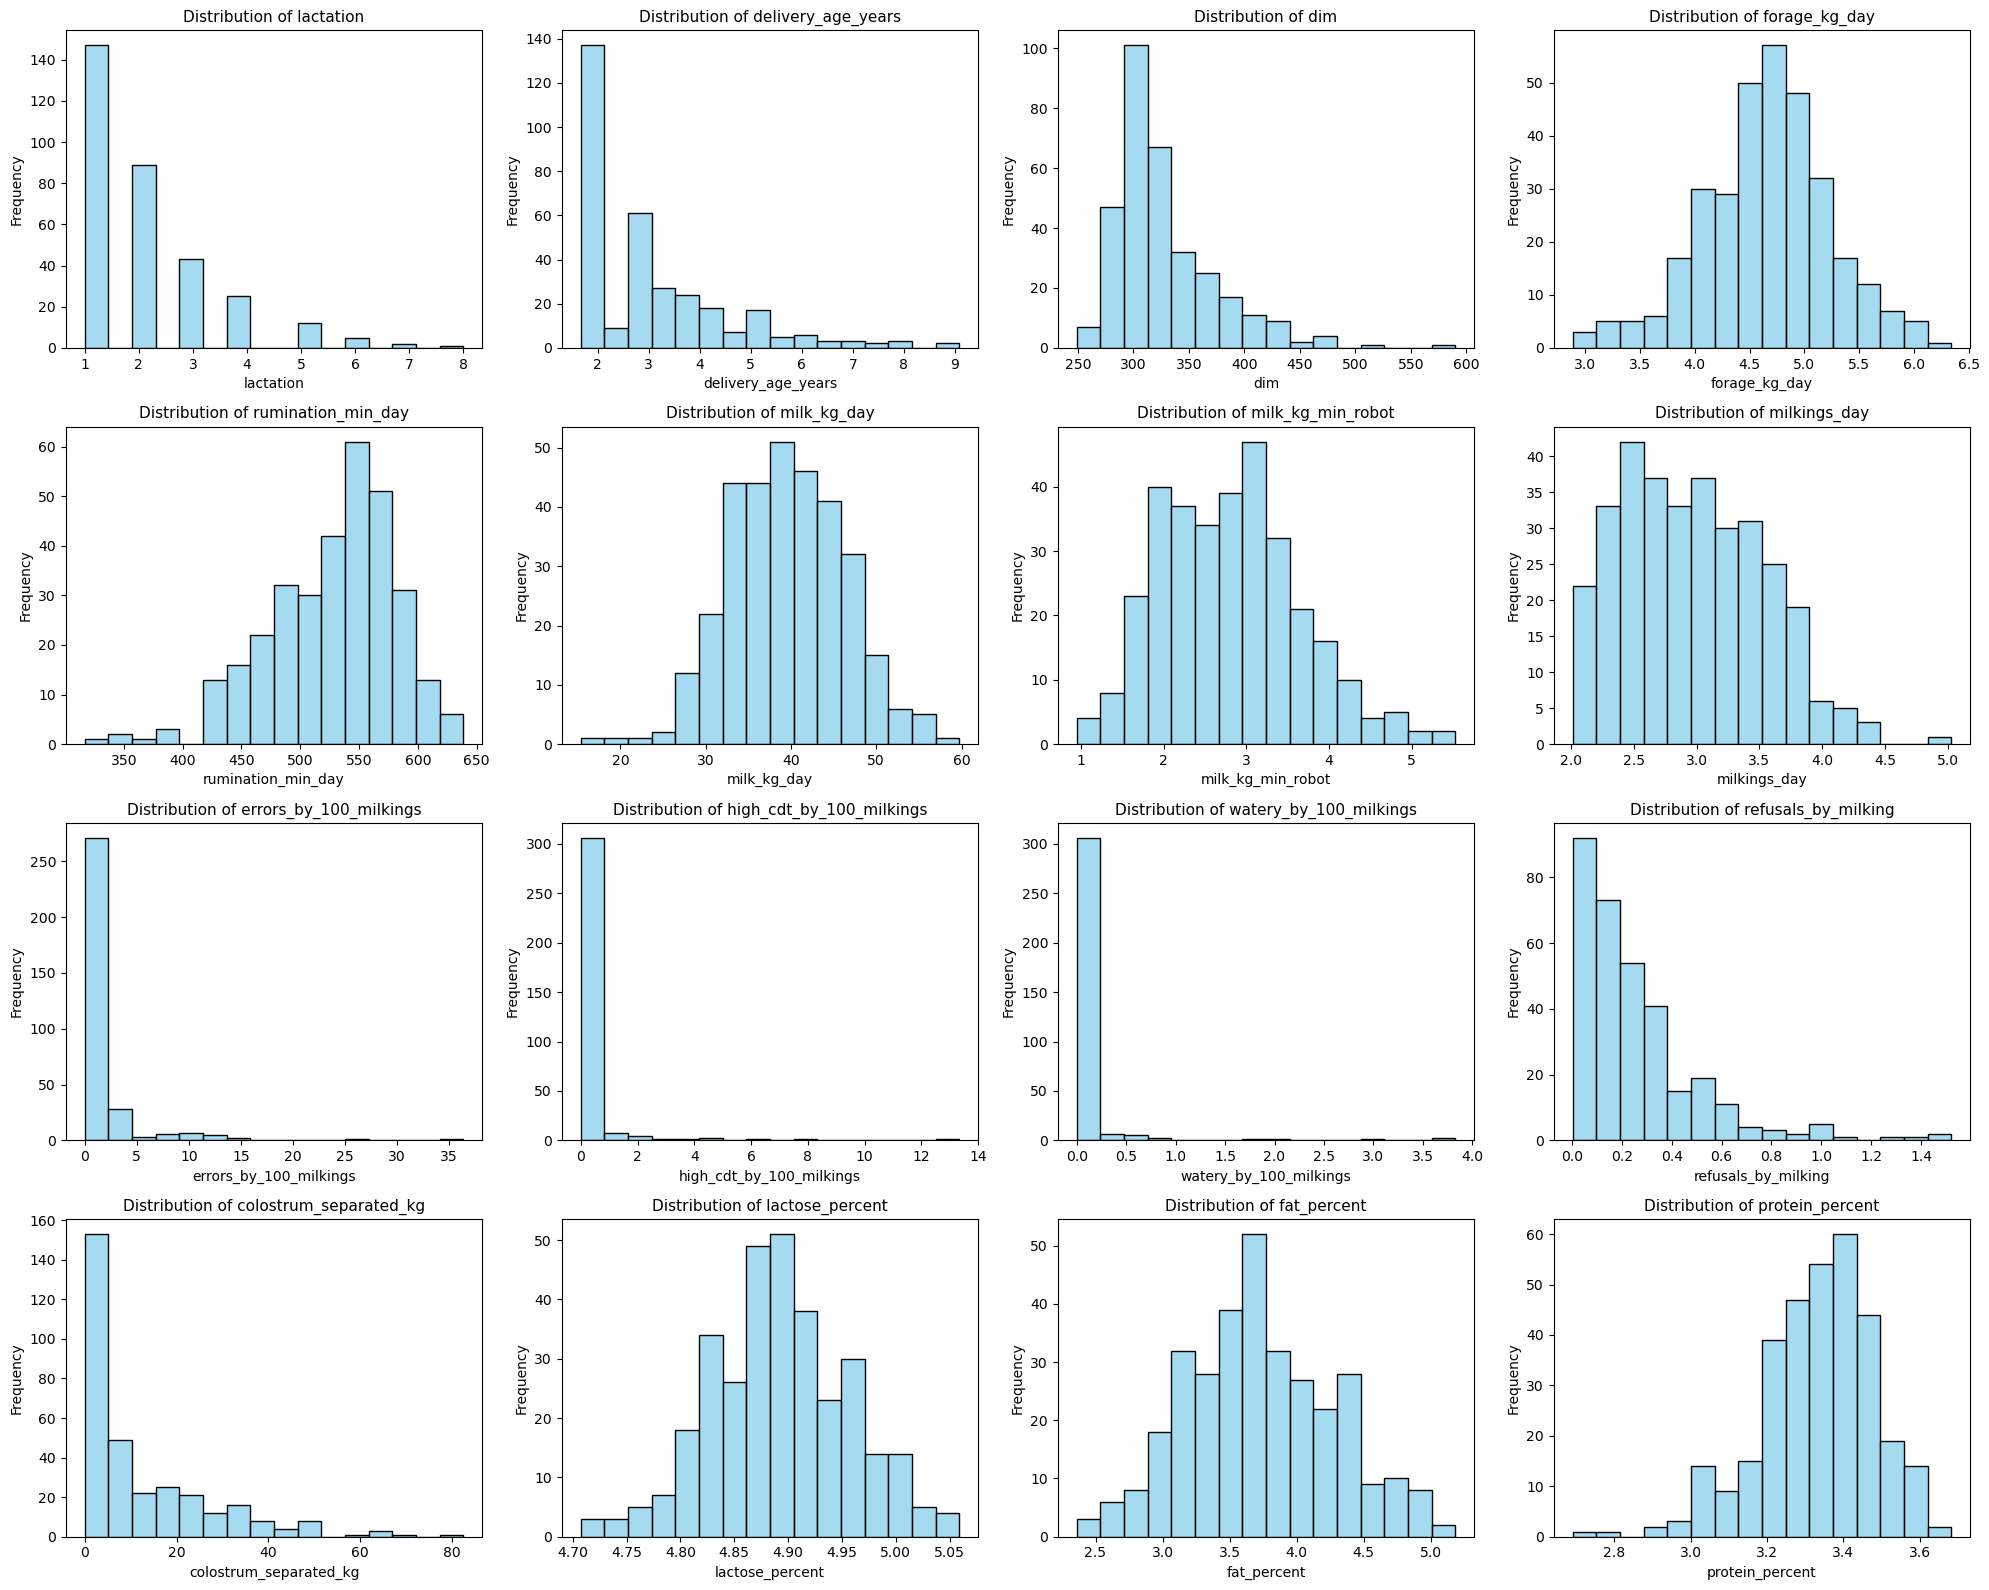

In [15]:
num_columns = len(data.columns)

# Number of rows and columns for subplots
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
#lactation is categorical so we did one hot encoding here
data = pd.get_dummies(data, columns=['lactation'])
data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)

/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_95185/239395984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
319    0
320    0
321    0
322    0
323    0
Name: lactation_2, Length: 324, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)
/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_95185/239395984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
319    0
320    0
321    0
322    0
323    0
Name: lactation_3, Length: 324, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)
/var/folders/rk/jdn7ny3s5pz59wz4cb1y

In [17]:
data.head()

delivery_age_years  dim  forage_kg_day  rumination_min_day  milk_kg_day  \
0            7.750000  414       4.310918          434.814010    34.082367   
1            9.083333  357       4.167087          589.500000    36.170868   
2            7.666667  315       4.903333          542.577778    43.371746   
3            8.666667  362       4.294724          628.371901    41.683149   
4            6.500000  427       4.798618          479.334112    37.916393   

   milk_kg_min_robot  milkings_day  errors_by_100_milkings  \
0           3.695699      2.478261                2.046784   
1           4.024165      2.176471                0.900901   
2           2.715252      2.387302                1.063830   
3           2.733291      2.193370                1.763224   
4           1.888608      3.142857                0.745156   

   high_cdt_by_100_milkings  watery_by_100_milkings  ...  fat_percent  \
0                       0.0                0.000000  ...     3.787156   
1                       0.0                0.000000  ...     3.645519   
2                       0.0                0.132979  ...     3.458251   
3                       0.0                0.000000  ...     3.407140   
4                       0.0                0.000000  ...     4.902554   

   protein_percent  lactation_1  lactation_2  lactation_3  lactation_4  \
0         3.511685        False            0            0            0   
1         3.470806        False            0            0            0   
2         3.370124        False            0            0            0   
3         3.221164        False            0            0            0   
4         3.395152        False            0            0            0   

   lactation_5  lactation_6  lactation_7  lactation_8  
0            0            0            1            0  
1            0            0            0            1  
2            0            1            0            0  
3            0            0            1            0  
4            1            0            0            0  

[5 rows x 23 columns]

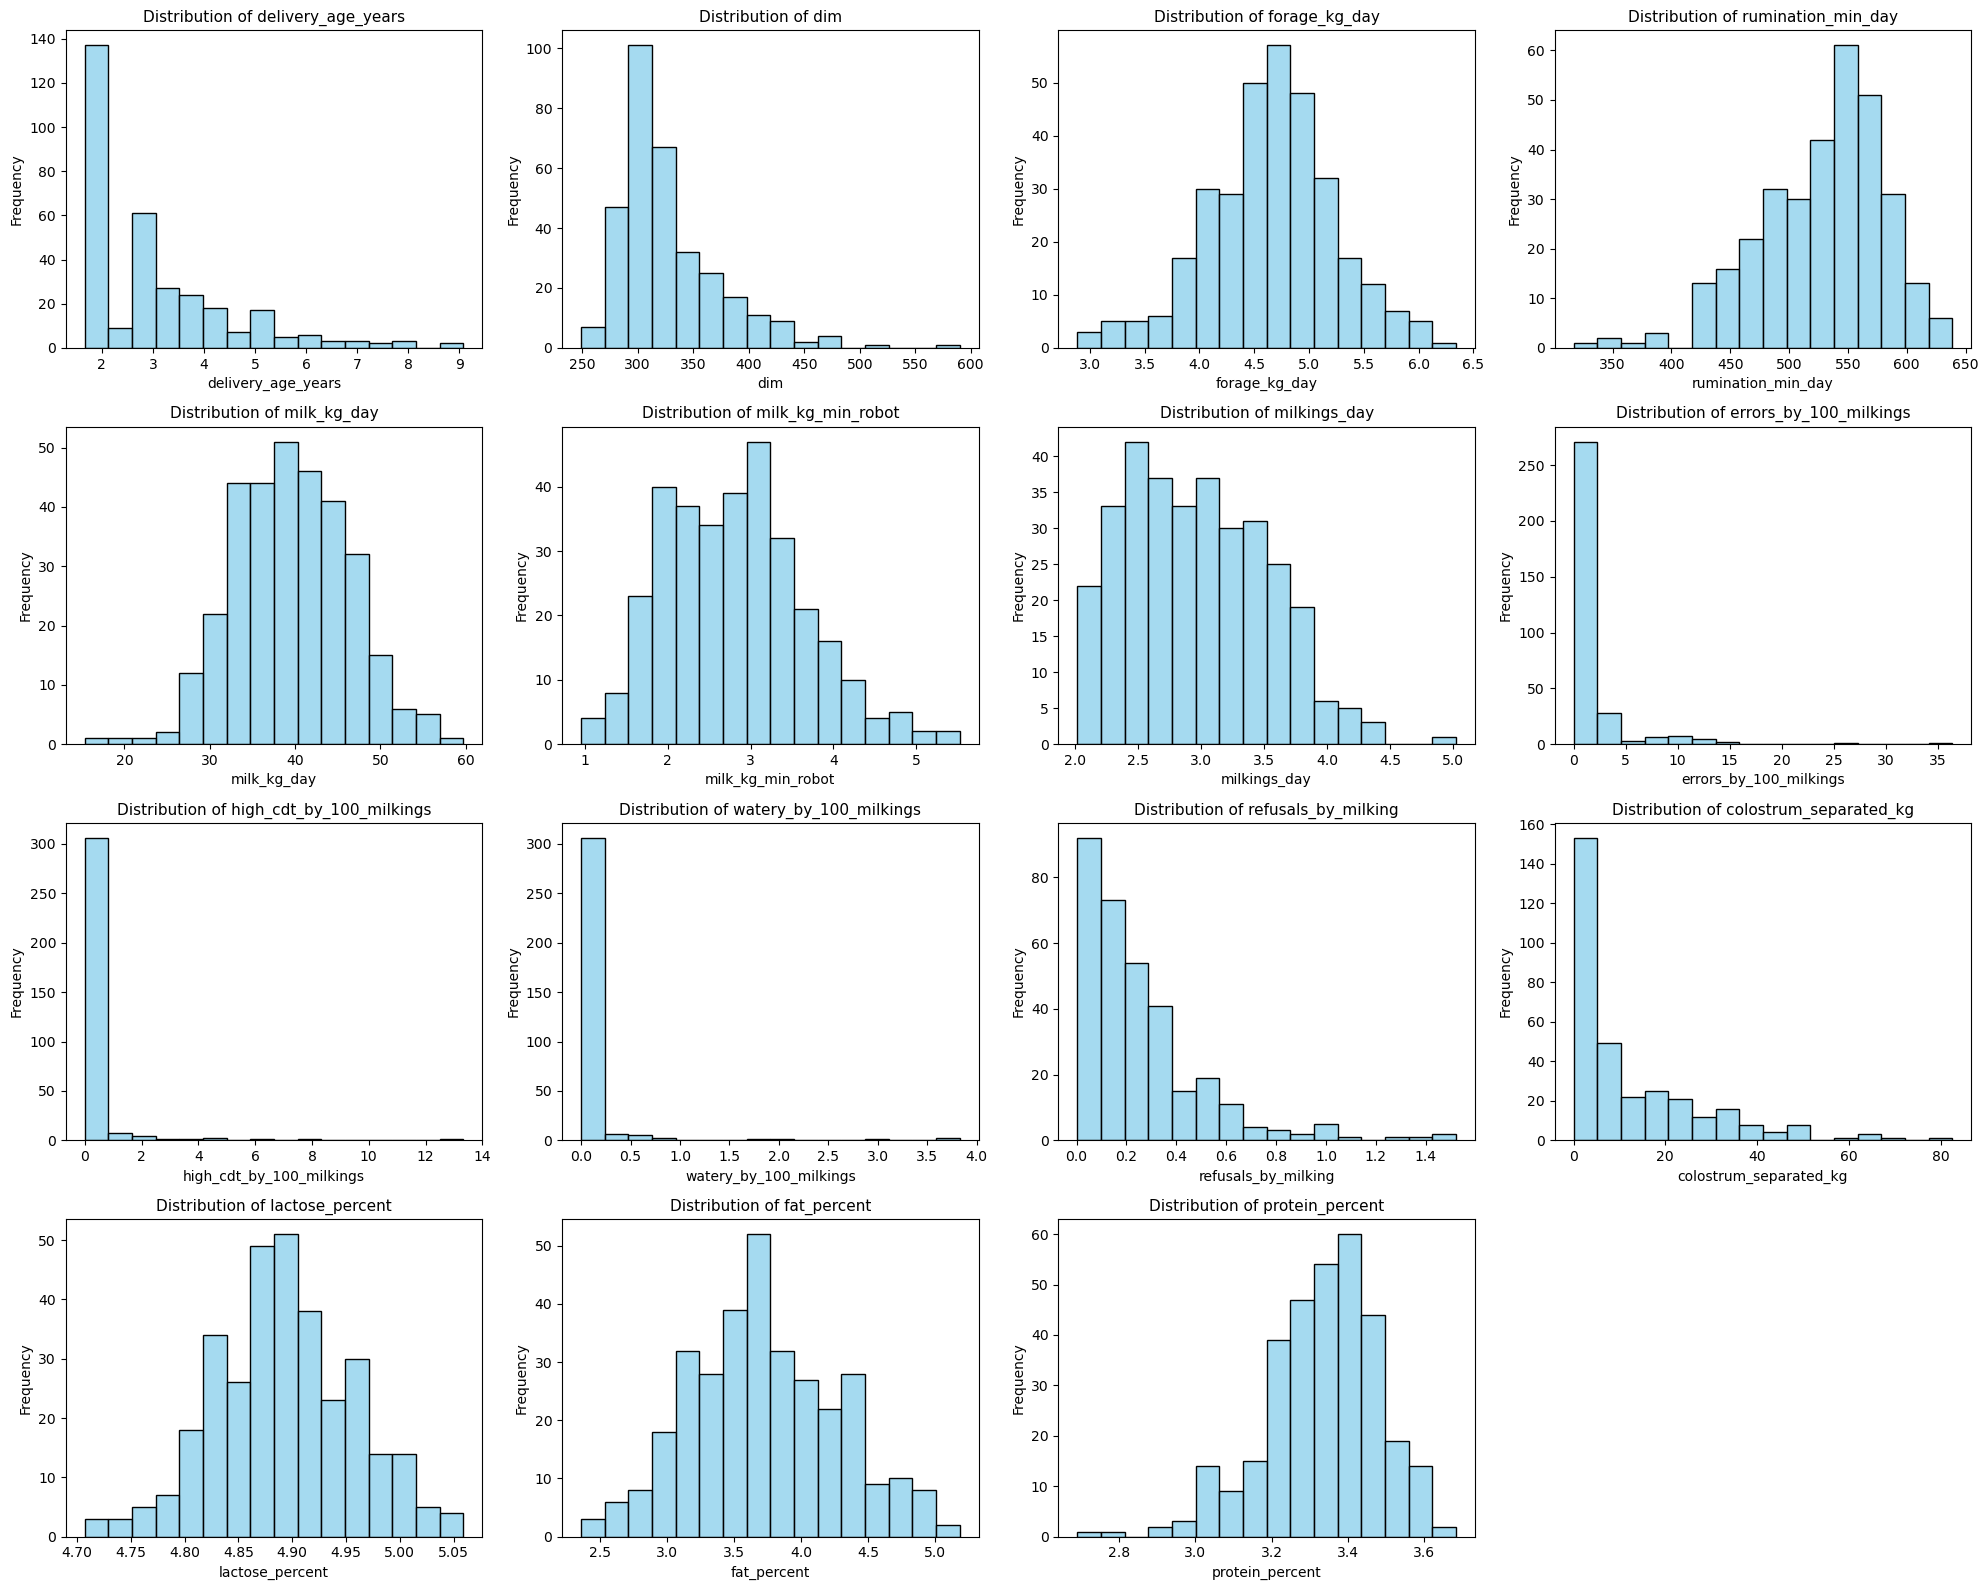

In [18]:
columns_to_plot = [col for col in data.columns if not col.startswith('lactation_')]

num_columns = len(columns_to_plot)

n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
X = data.drop(columns=["fat_percent", "lactose_percent", "protein_percent"])
y_fat = data["fat_percent"]
y_lactose = data["lactose_percent"]
y_protein = data["protein_percent"]

In [21]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scaler = StandardScaler()

X_train_kf, X_val_kf = [], []
y_fat_train_kf, y_fat_val_kf = [], []
y_lactose_train_kf, y_lactose_val_kf = [], []
y_protein_train_kf, y_protein_val_kf = [], []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fat_train_fold, y_fat_val_fold = y_fat.iloc[train_index], y_fat.iloc[val_index]
    y_lactose_train_fold, y_lactose_val_fold = y_lactose.iloc[train_index], y_lactose.iloc[val_index]
    y_protein_train_fold, y_protein_val_fold = y_protein.iloc[train_index], y_protein.iloc[val_index]

    # Scaler
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Convert to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32)
    X_val_fold_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32)
    y_fat_train_fold_tensor = torch.tensor(y_fat_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_fat_val_fold_tensor = torch.tensor(y_fat_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_train_fold_tensor = torch.tensor(y_lactose_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_val_fold_tensor = torch.tensor(y_lactose_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_train_fold_tensor = torch.tensor(y_protein_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_val_fold_tensor = torch.tensor(y_protein_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)

    # Append to lists
    X_train_kf.append(X_train_fold_tensor)
    X_val_kf.append(X_val_fold_tensor)
    y_fat_train_kf.append(y_fat_train_fold_tensor)
    y_fat_val_kf.append(y_fat_val_fold_tensor)
    y_lactose_train_kf.append(y_lactose_train_fold_tensor)
    y_lactose_val_kf.append(y_lactose_val_fold_tensor)
    y_protein_train_kf.append(y_protein_train_fold_tensor)
    y_protein_val_kf.append(y_protein_val_fold_tensor)

In [22]:
def dataloaders(X_train_kf, X_val_kf, y_train_kf, y_val_kf, batch_sizes):
    train_data = []
    val_data = []

    for i in range(len(X_train_kf)):
        train_ds = TensorDataset(X_train_kf[i], y_train_kf[i])
        val_ds = TensorDataset(X_val_kf[i], y_val_kf[i])

        batch_size_GD = batch_sizes['GD']
        batch_size_SGD = batch_sizes['SGD']
        batch_size_MiniSGD = batch_sizes['MiniSGD']
        batch_size_ASGD = batch_sizes['ASGD']
        batch_size_RMSprop = batch_sizes['RMSprop']

        train_dl_GD = DataLoader(train_ds, batch_size_GD, shuffle=True)
        val_dl_GD = DataLoader(val_ds, batch_size_GD, shuffle=True)
        train_dl_SGD = DataLoader(train_ds, batch_size_SGD, shuffle=True)
        val_dl_SGD = DataLoader(val_ds, batch_size_SGD, shuffle=True)
        train_dl_MiniSGD = DataLoader(train_ds, batch_size_MiniSGD, shuffle=True)
        val_dl_MiniSGD = DataLoader(val_ds, batch_size_MiniSGD, shuffle=True)
        train_dl_ASGD = DataLoader(train_ds, batch_size_ASGD, shuffle=True)
        val_dl_ASGD = DataLoader(val_ds, batch_size_ASGD, shuffle=True)
        train_dl_RMSprop = DataLoader(train_ds, batch_size_RMSprop, shuffle=True)
        val_dl_RMSprop = DataLoader(val_ds, batch_size_RMSprop, shuffle=True)
        
        train_data.append({
            'GD': train_dl_GD,
            'SGD': train_dl_SGD,
            'MiniSGD': train_dl_MiniSGD,
            'ASGD': train_dl_ASGD,
            'RMSprop': train_dl_RMSprop
        })

        val_data.append({
            'GD': val_dl_GD,
            'SGD': val_dl_SGD,
            'MiniSGD': val_dl_MiniSGD,
            'ASGD': val_dl_ASGD,
            'RMSprop': val_dl_RMSprop
        })

    return train_data, val_data

# Define batch sizes for each optimizer
batch_sizes = {
    'GD': X_train_kf[0].shape[0],
    'SGD': 1,
    'MiniSGD': 32,
    'ASGD': 64,
    'RMSprop': 128
}

# Get dataloaders for each percentage
fat_train_data, fat_val_data = dataloaders(X_train_kf, X_val_kf, y_fat_train_kf, y_fat_val_kf, batch_sizes)
lactose_train_data, lactose_val_data = dataloaders(X_train_kf, X_val_kf, y_lactose_train_kf, y_lactose_val_kf, batch_sizes)
protein_train_data, protein_val_data = dataloaders(X_train_kf, X_val_kf, y_protein_train_kf, y_protein_val_kf, batch_sizes)

In [23]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def train_model(self, num_epochs, loss_fn, optimizer, train_dl, val_dl, train_size, val_size, batch_size):
        self.apply(self._init_weights)
        loss_hist_train = [0] * num_epochs
        rmse_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        rmse_hist_valid = [0] * num_epochs

        for epoch in tqdm(range(num_epochs)):
            epoch_train_loss = 0
            train_predictions = []
            train_targets = []
            self.train()
            for x_batch, y_batch in train_dl:
                pred = self(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_train_loss += loss.item()
                train_predictions.append(pred.detach().cpu().numpy())
                train_targets.append(y_batch.detach().cpu().numpy())

            train_predictions = np.concatenate(train_predictions)
            train_targets = np.concatenate(train_targets)
            loss_hist_train[epoch] = epoch_train_loss / (train_size / batch_size)
            rmse_hist_train[epoch] = compute_rmse(train_predictions, train_targets)

            self.eval()
            with torch.no_grad():
                val_predictions = []
                val_targets = []
                for x_batch, y_batch in val_dl:
                    pred = self(x_batch)
                    val_predictions.append(pred.detach().cpu().numpy())
                    val_targets.append(y_batch.detach().cpu().numpy())

                val_predictions = np.concatenate(val_predictions)
                val_targets = np.concatenate(val_targets)
                valid_loss = loss_fn(torch.tensor(val_predictions), torch.tensor(val_targets)).item()
                loss_hist_valid[epoch] = valid_loss
                rmse_hist_valid[epoch] = compute_rmse(val_predictions, val_targets)

        return loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid


# Function to compute RMSE
def compute_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def train_and_evaluate_kfold(model, optimizer, num_epochs, loss_fn, X_kf, y_kf):
    history = {}

    for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
        print(f"Training models for fold {fold_idx + 1}...")
        train_ds = TensorDataset(X_train_fold, y_train_fold)
        val_ds = TensorDataset(X_val_fold, y_val_fold)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model_instance = model(input_dim=X_train_fold.shape[1])
        optimizer_instance = optimizer(model_instance.parameters(), lr=learning_rate)

        history_fold = model_instance.train_model(
            num_epochs=num_epochs,
            loss_fn=loss_fn,
            optimizer=optimizer_instance,
            train_dl=train_dl,
            val_dl=val_dl,
            train_size=len(train_dl.dataset),
            val_size=len(val_dl.dataset),
            batch_size=batch_size
        )

        history[f'Fold_{fold_idx + 1}'] = history_fold

    return history

# Instantiate the neural networks for each target variable
input_dim = X_train_fold.shape[1]
nn_names = ['GD', 'SGD', 'MiniSGD', 'ASGD', 'RMSprop']
nn_torch = {k: Net(input_dim) for k in nn_names}

# Define loss function
loss_fn = nn.MSELoss()

# Define learning rates
learning_rates = {
    'GD': 0.05,
    'SGD': 0.05,
    'MiniSGD': 0.05,
    'ASGD': 0.05,
    'RMSprop': 0.05
}

# Define optimizers
optimizers = {
    'GD': torch.optim.SGD,
    'SGD': torch.optim.SGD,
    'MiniSGD': torch.optim.SGD,
    'ASGD': torch.optim.ASGD,
    'RMSprop': torch.optim.RMSprop
}
num_epochs = 20

In [24]:

# Function to prepare data for k-fold cross-validation
def prepare_kfold_data(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scaler = StandardScaler()

    X_kf, y_kf = [], []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
        y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

        X_kf.append((X_train_tensor, X_val_tensor))
        y_kf.append((y_train_tensor, y_val_tensor))

    return X_kf, y_kf

def train_and_evaluate_kfold(models, optimizers, num_epochs, loss_fn, X_kf, y_kf):
    history = {}

    for nn_name, model in models.items():
        optimizer = optimizers[nn_name]
        history_nn = {}
        for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
            print(f"Training {nn_name} for fold {fold_idx + 1}...")
            train_ds = TensorDataset(X_train_fold, y_train_fold)
            val_ds = TensorDataset(X_val_fold, y_val_fold)

            # Retrieve the batch size for the current optimizer
            batch_size = batch_sizes[nn_name]

            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

            optimizer_instance = optimizer(model.parameters(), lr=learning_rates[nn_name])

            history_fold = model.train_model(
                num_epochs=num_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer_instance,
                train_dl=train_dl,
                val_dl=val_dl,
                train_size=len(train_dl.dataset),
                val_size=len(val_dl.dataset),
                batch_size=batch_size  # Use the retrieved batch size
            )

            history_nn[f'Fold_{fold_idx + 1}'] = history_fold

        history[nn_name] = history_nn

    return history




X_fat_kf, y_fat_kf = prepare_kfold_data(X, y_fat, k)
X_lactose_kf, y_lactose_kf = prepare_kfold_data(X, y_lactose, k)
X_protein_kf, y_protein_kf = prepare_kfold_data(X, y_protein, k)


# Call the function with the appropriate parameters
history_kfold_fat = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_fat_kf, y_fat_kf)
history_kfold_lactose = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_lactose_kf, y_lactose_kf)
history_kfold_protein = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_protein_kf, y_protein_kf)


Training GD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 35.53it/s]


Training GD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 238.19it/s]


Training GD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 262.28it/s]


Training GD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 229.80it/s]


Training GD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 229.02it/s]


Training SGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 24.05it/s]


Training SGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 23.49it/s]


Training SGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 23.24it/s]


Training SGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 22.55it/s]


Training SGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 21.37it/s]


Training MiniSGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 379.59it/s]


Training MiniSGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 377.98it/s]


Training MiniSGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 394.59it/s]


Training MiniSGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 407.59it/s]


Training MiniSGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 416.84it/s]


Training ASGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 407.91it/s]


Training ASGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 449.41it/s]


Training ASGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 438.26it/s]


Training ASGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 440.09it/s]


Training ASGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 464.78it/s]


Training RMSprop for fold 1...


100%|██████████| 20/20 [00:00<00:00, 582.82it/s]


Training RMSprop for fold 2...


100%|██████████| 20/20 [00:00<00:00, 650.92it/s]


Training RMSprop for fold 3...


100%|██████████| 20/20 [00:00<00:00, 650.56it/s]


Training RMSprop for fold 4...


100%|██████████| 20/20 [00:00<00:00, 637.33it/s]


Training RMSprop for fold 5...


100%|██████████| 20/20 [00:00<00:00, 642.65it/s]


Training GD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 263.72it/s]


Training GD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 324.79it/s]


Training GD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 263.32it/s]


Training GD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 305.85it/s]


Training GD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 277.58it/s]


Training SGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 23.43it/s]


Training SGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 23.74it/s]


Training SGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 24.26it/s]


Training SGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 24.58it/s]


Training SGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 24.66it/s]


Training MiniSGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 450.39it/s]


Training MiniSGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 438.84it/s]


Training MiniSGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 424.70it/s]


Training MiniSGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 447.56it/s]


Training MiniSGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 453.53it/s]


Training ASGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 489.81it/s]


Training ASGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 496.46it/s]


Training ASGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 495.47it/s]


Training ASGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 496.55it/s]


Training ASGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 509.23it/s]


Training RMSprop for fold 1...


100%|██████████| 20/20 [00:00<00:00, 718.36it/s]


Training RMSprop for fold 2...


100%|██████████| 20/20 [00:00<00:00, 715.79it/s]


Training RMSprop for fold 3...


100%|██████████| 20/20 [00:00<00:00, 717.10it/s]


Training RMSprop for fold 4...


100%|██████████| 20/20 [00:00<00:00, 721.01it/s]


Training RMSprop for fold 5...


100%|██████████| 20/20 [00:00<00:00, 722.20it/s]


Training GD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 231.97it/s]


Training GD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 202.07it/s]


Training GD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 232.87it/s]


Training GD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 224.59it/s]


Training GD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 208.67it/s]


Training SGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 24.68it/s]


Training SGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 23.46it/s]


Training SGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 24.43it/s]


Training SGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 23.39it/s]


Training SGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 22.97it/s]


Training MiniSGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 451.24it/s]


Training MiniSGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 452.49it/s]


Training MiniSGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 445.85it/s]


Training MiniSGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 451.96it/s]


Training MiniSGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 455.96it/s]


Training ASGD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 491.40it/s]


Training ASGD for fold 2...


100%|██████████| 20/20 [00:00<00:00, 493.08it/s]


Training ASGD for fold 3...


100%|██████████| 20/20 [00:00<00:00, 491.87it/s]


Training ASGD for fold 4...


100%|██████████| 20/20 [00:00<00:00, 491.15it/s]


Training ASGD for fold 5...


100%|██████████| 20/20 [00:00<00:00, 509.00it/s]


Training RMSprop for fold 1...


100%|██████████| 20/20 [00:00<00:00, 719.58it/s]


Training RMSprop for fold 2...


100%|██████████| 20/20 [00:00<00:00, 706.89it/s]


Training RMSprop for fold 3...


100%|██████████| 20/20 [00:00<00:00, 714.77it/s]


Training RMSprop for fold 4...


100%|██████████| 20/20 [00:00<00:00, 725.29it/s]


Training RMSprop for fold 5...


100%|██████████| 20/20 [00:00<00:00, 719.94it/s]


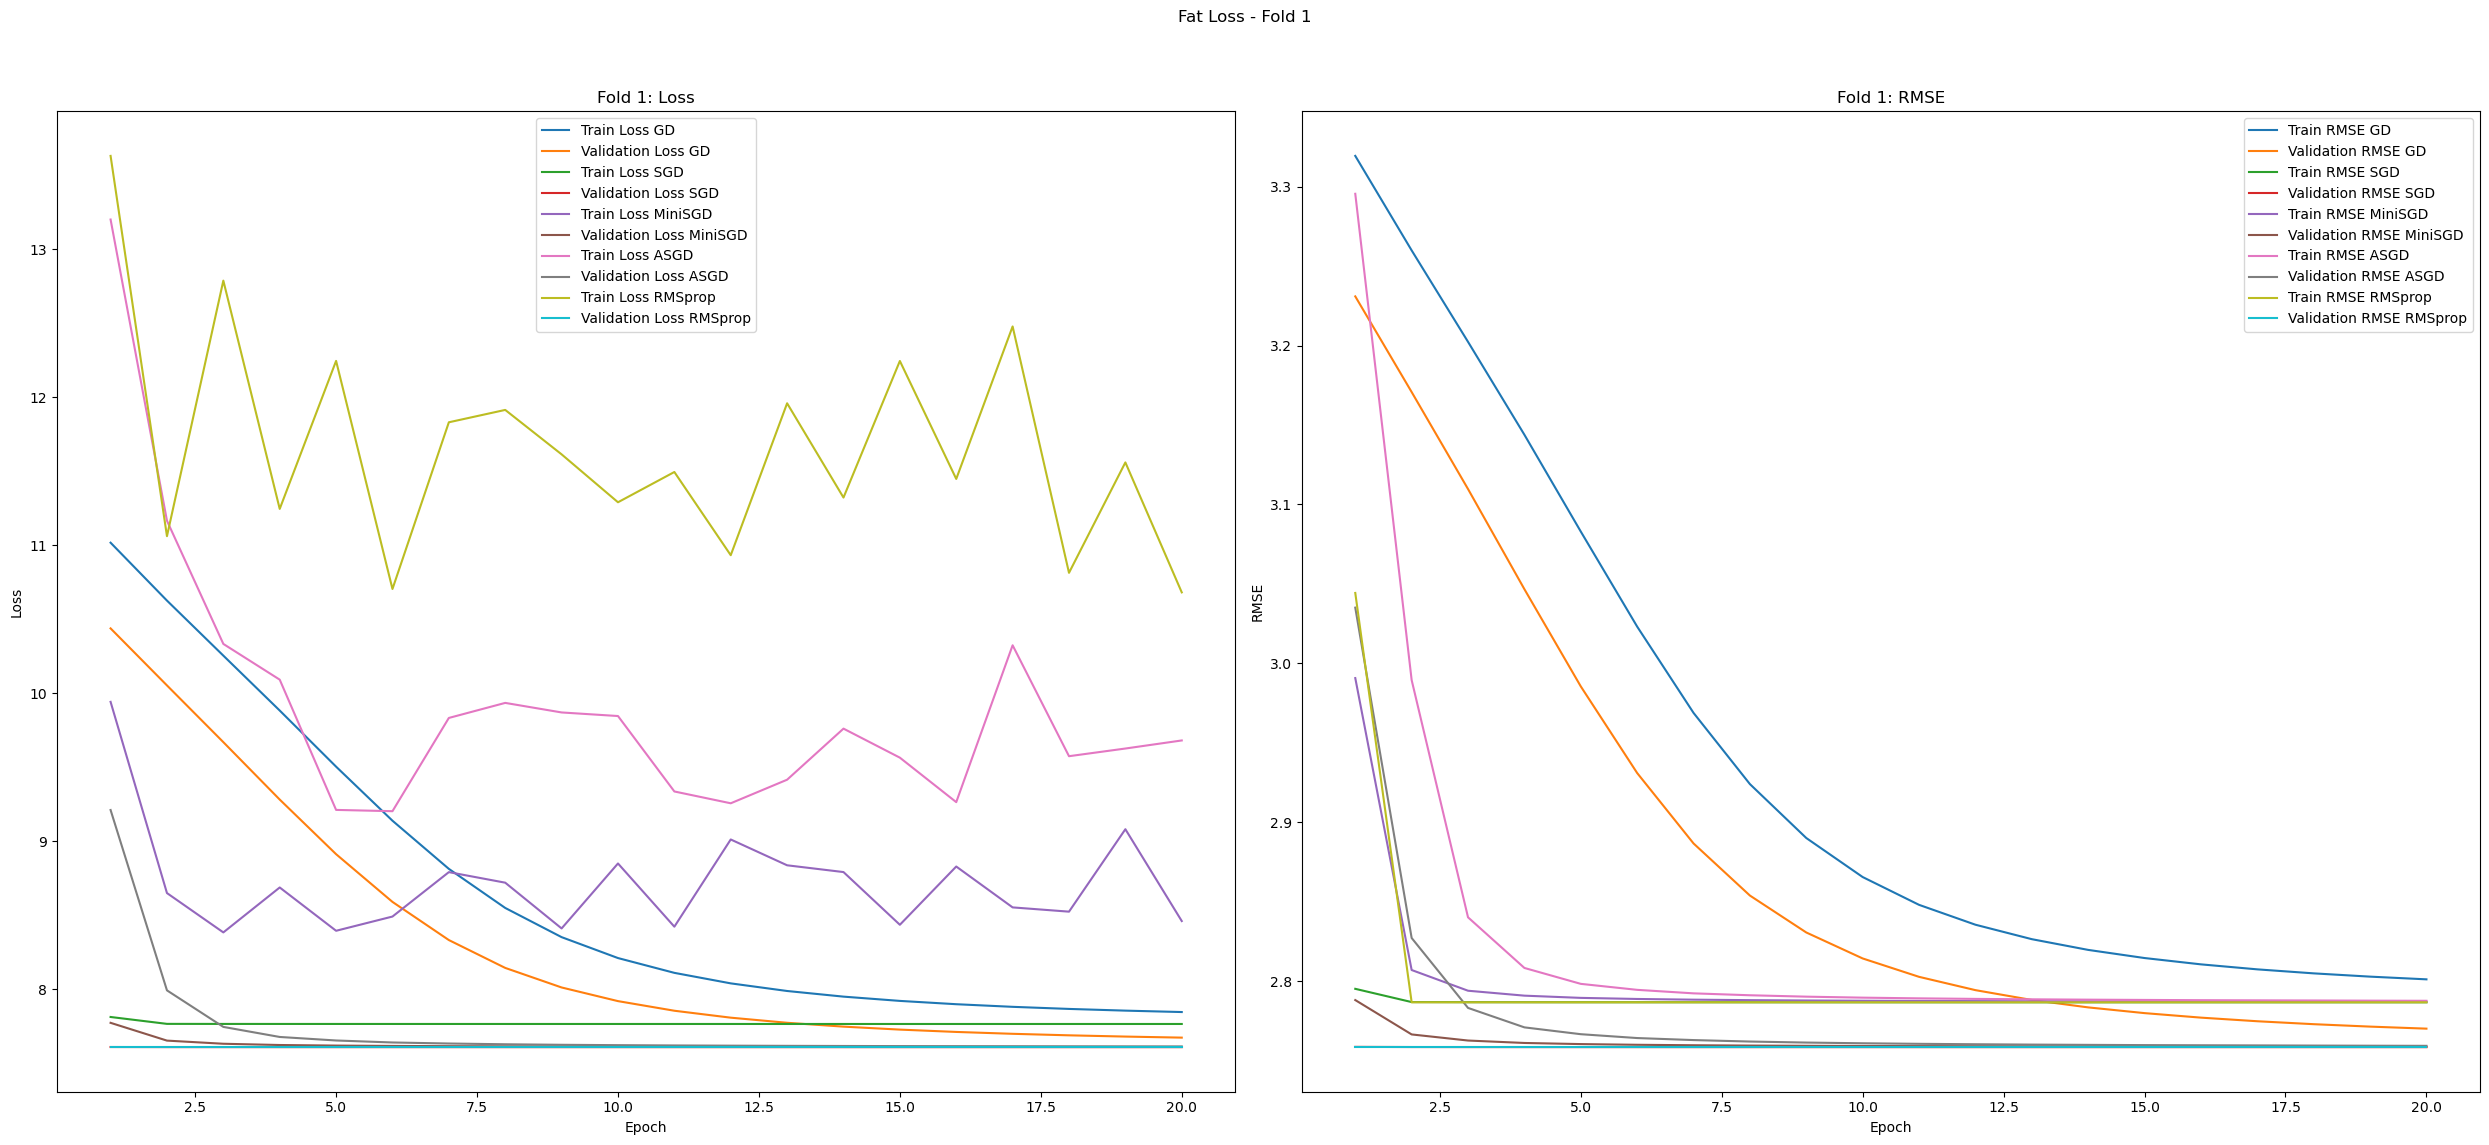

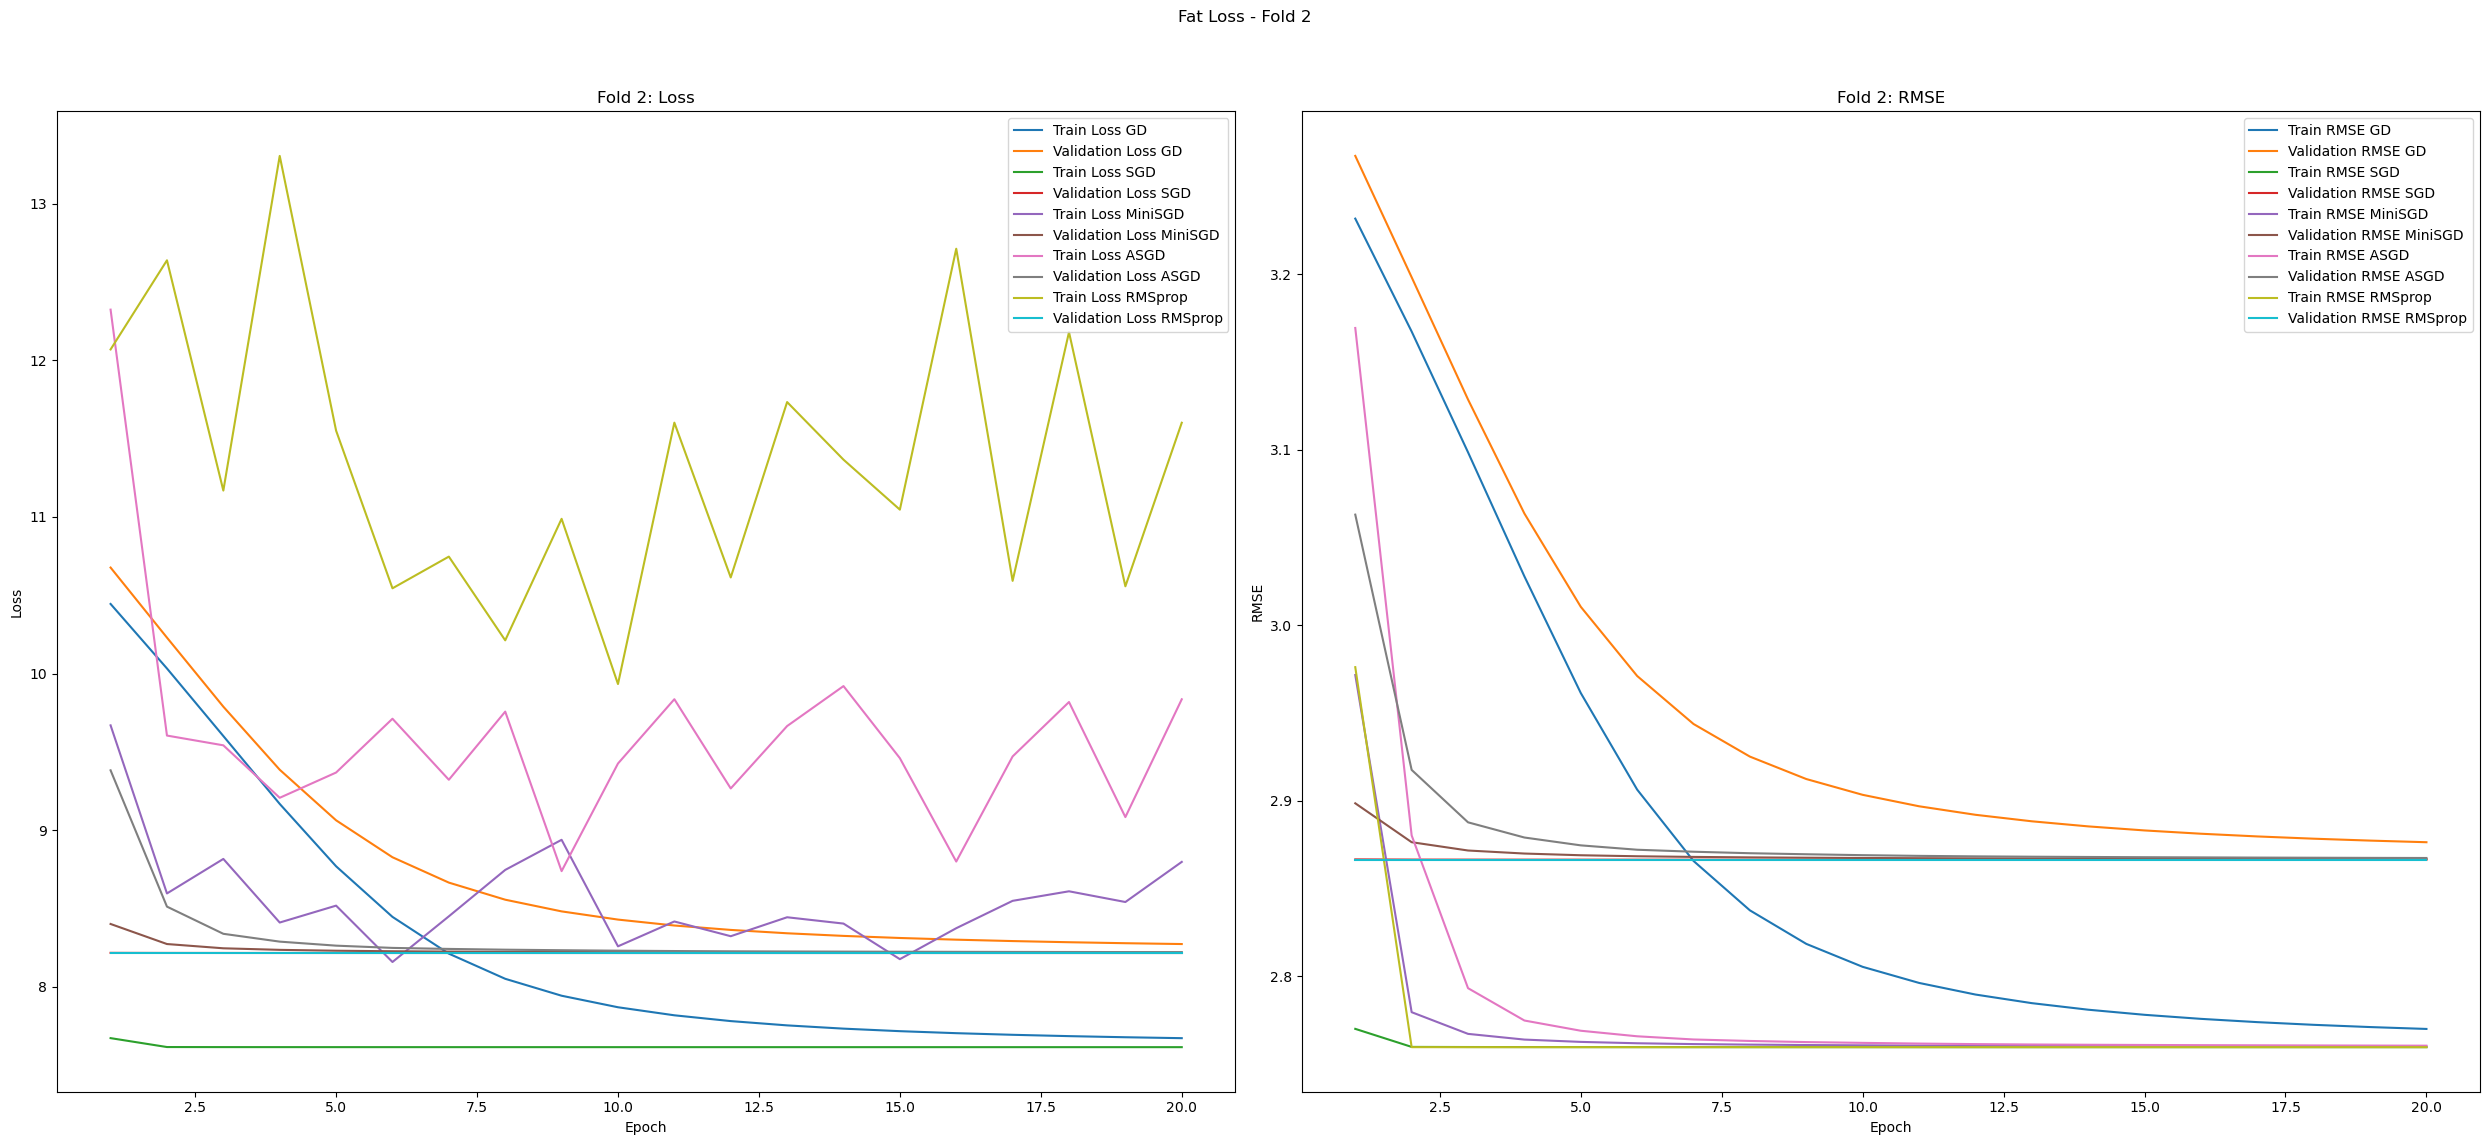

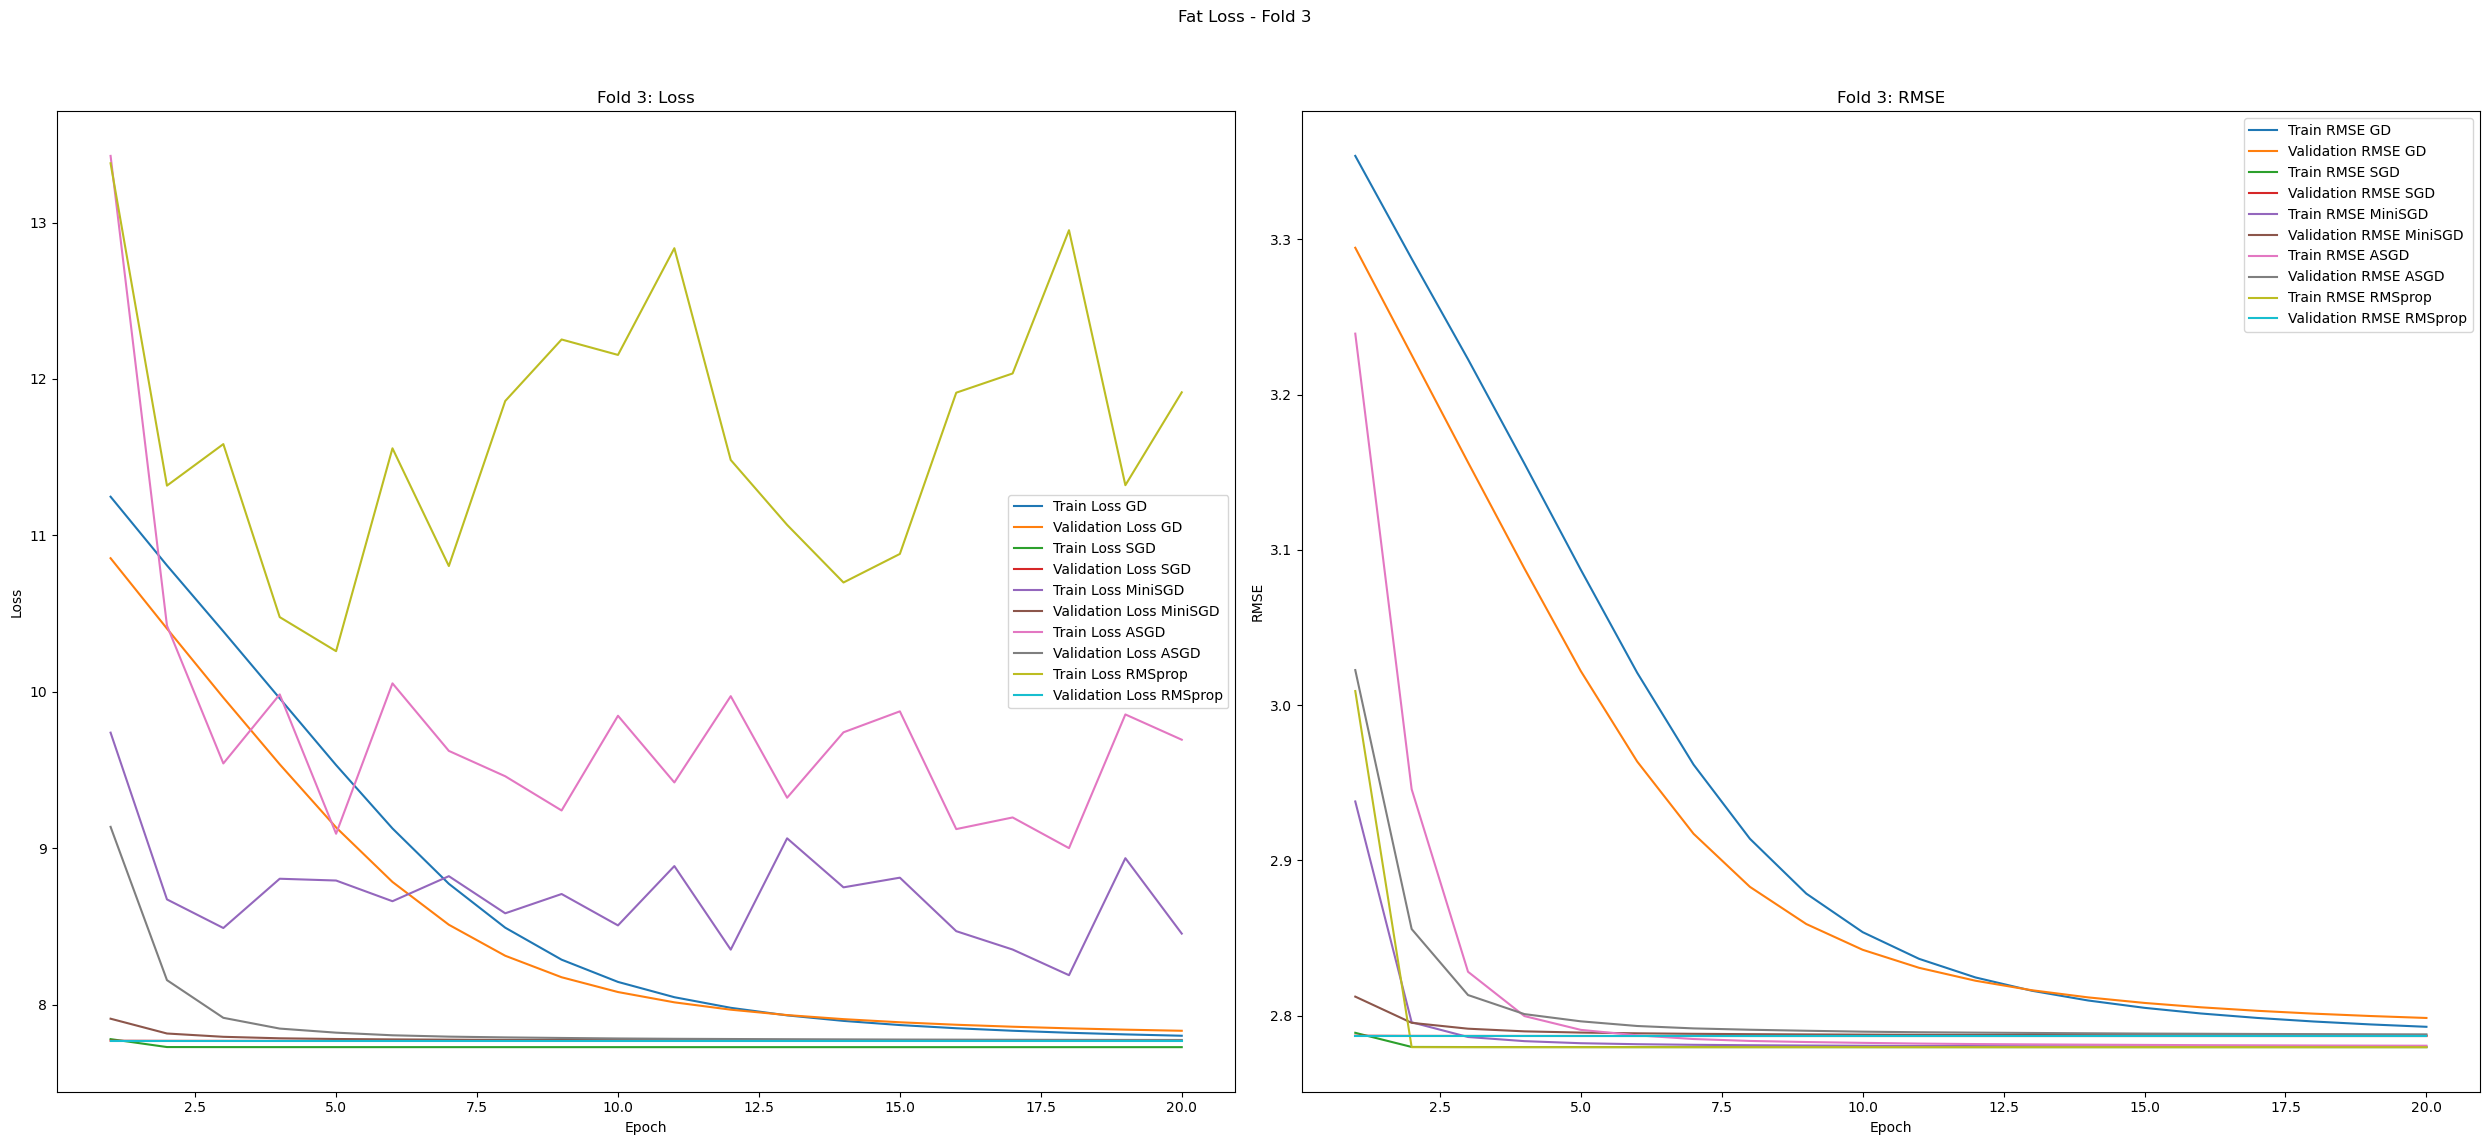

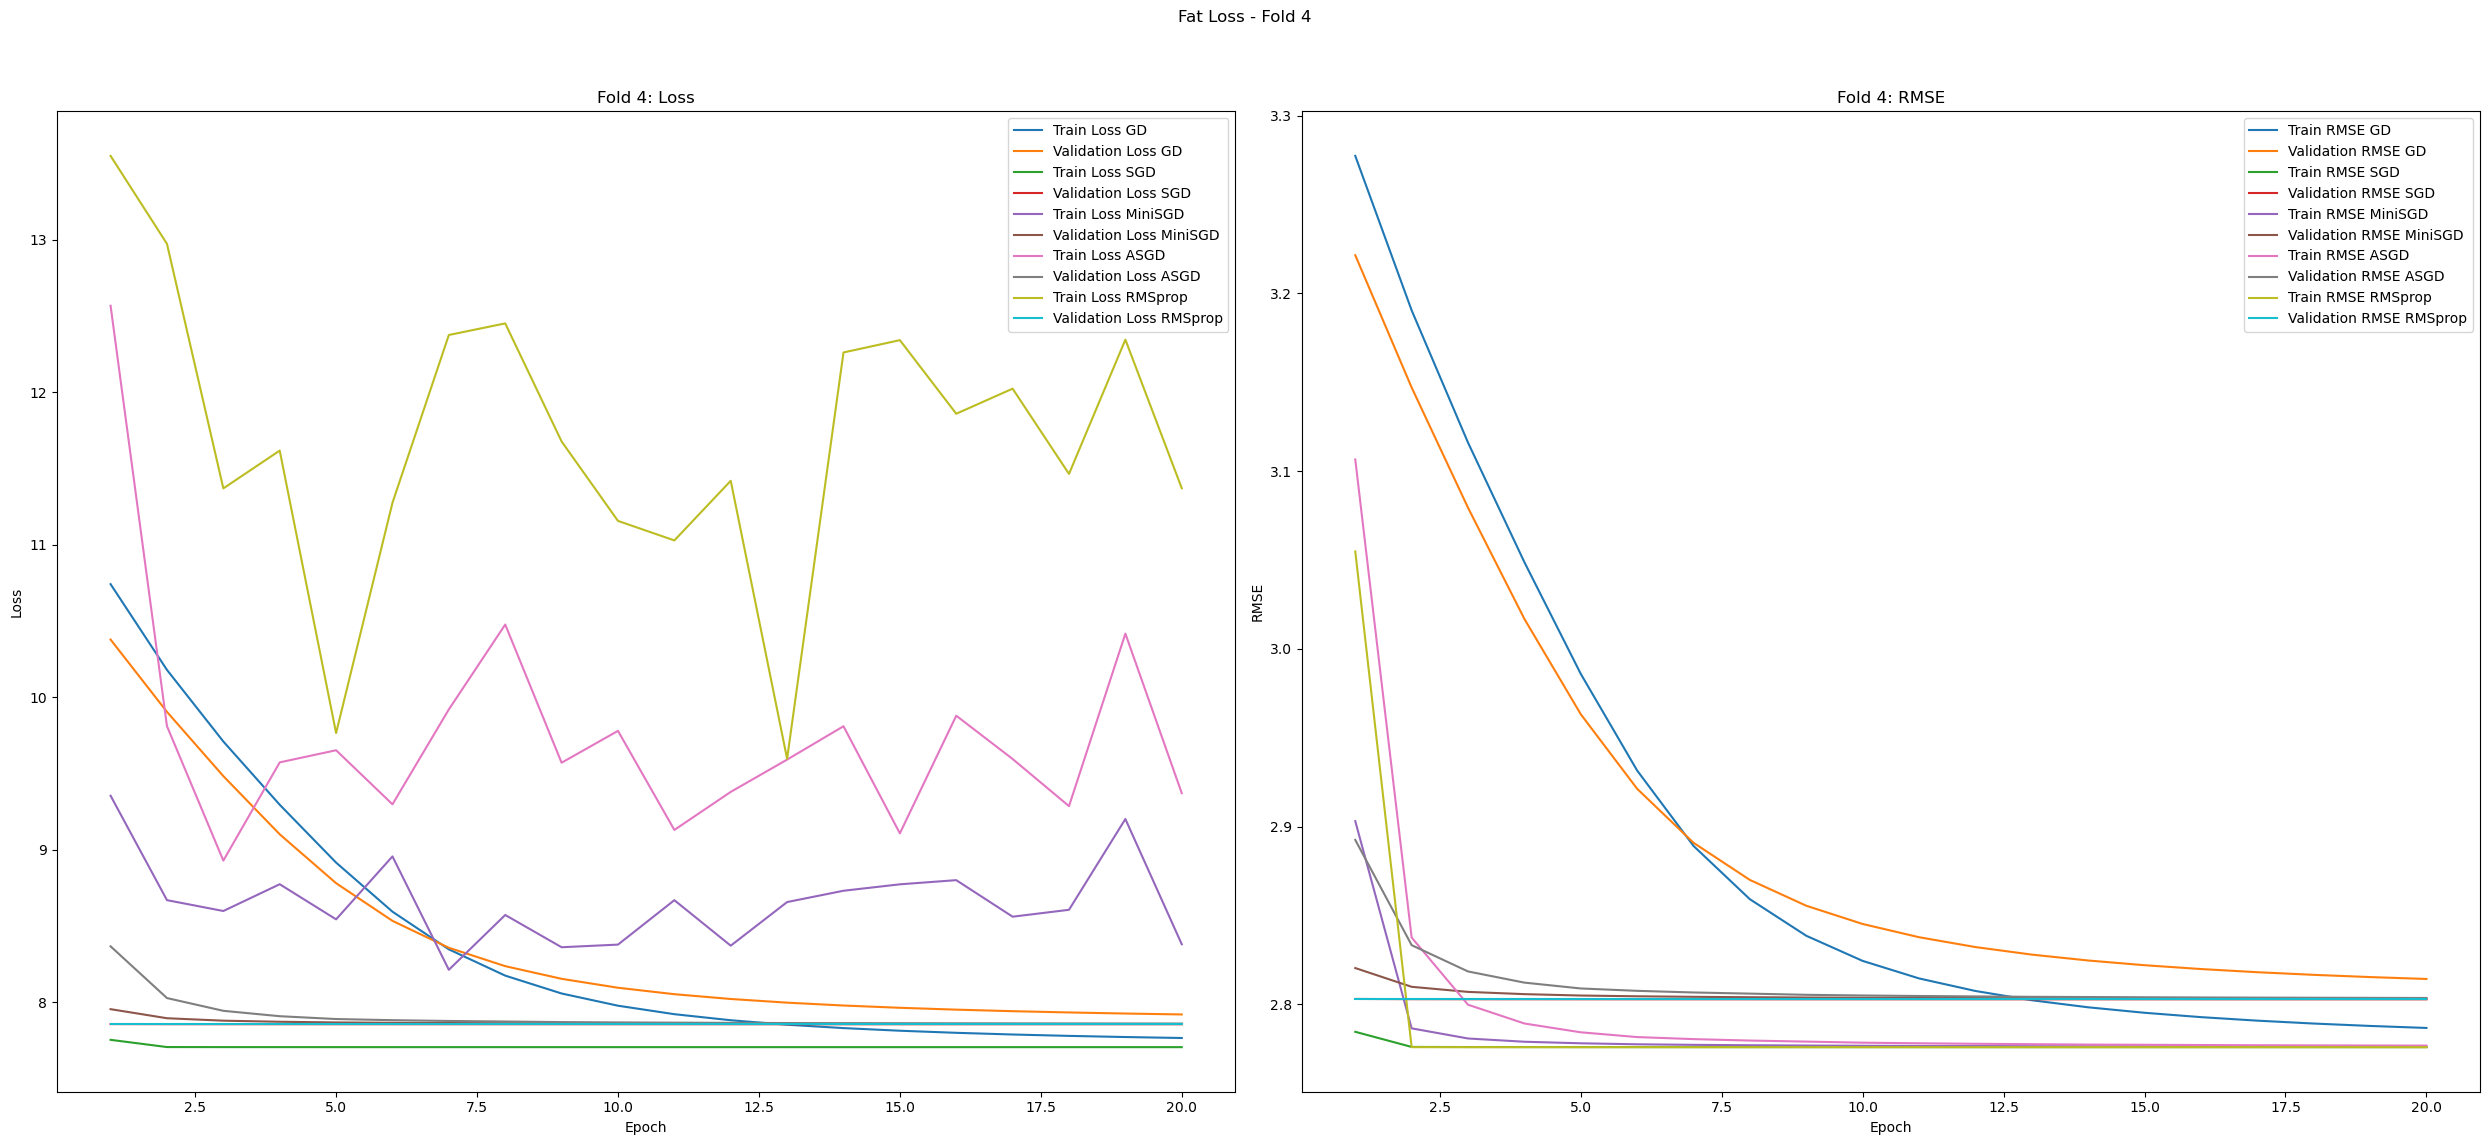

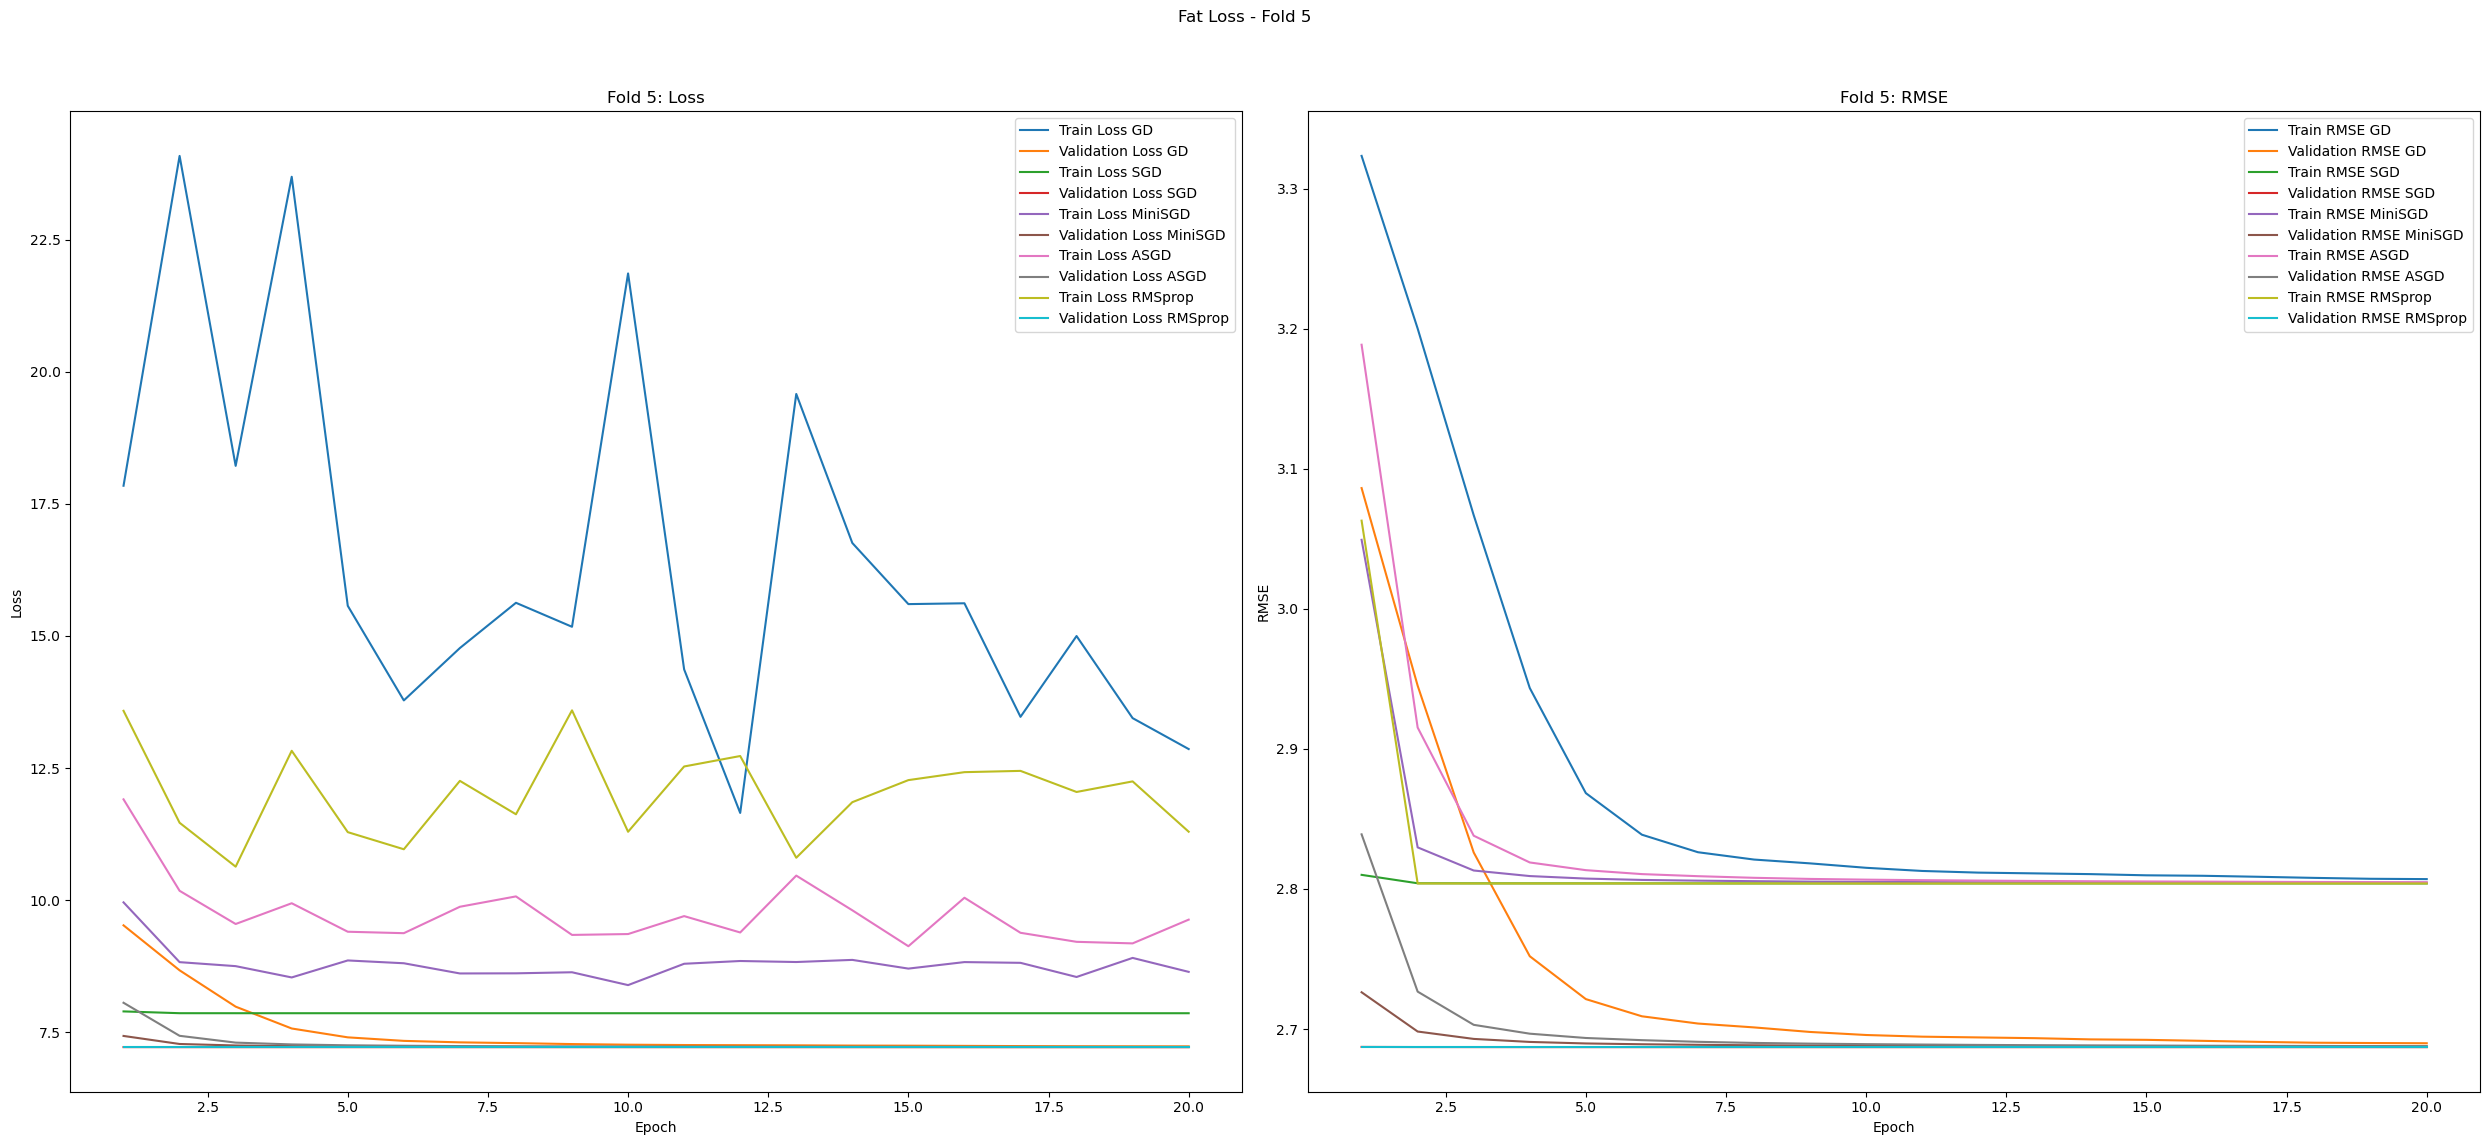

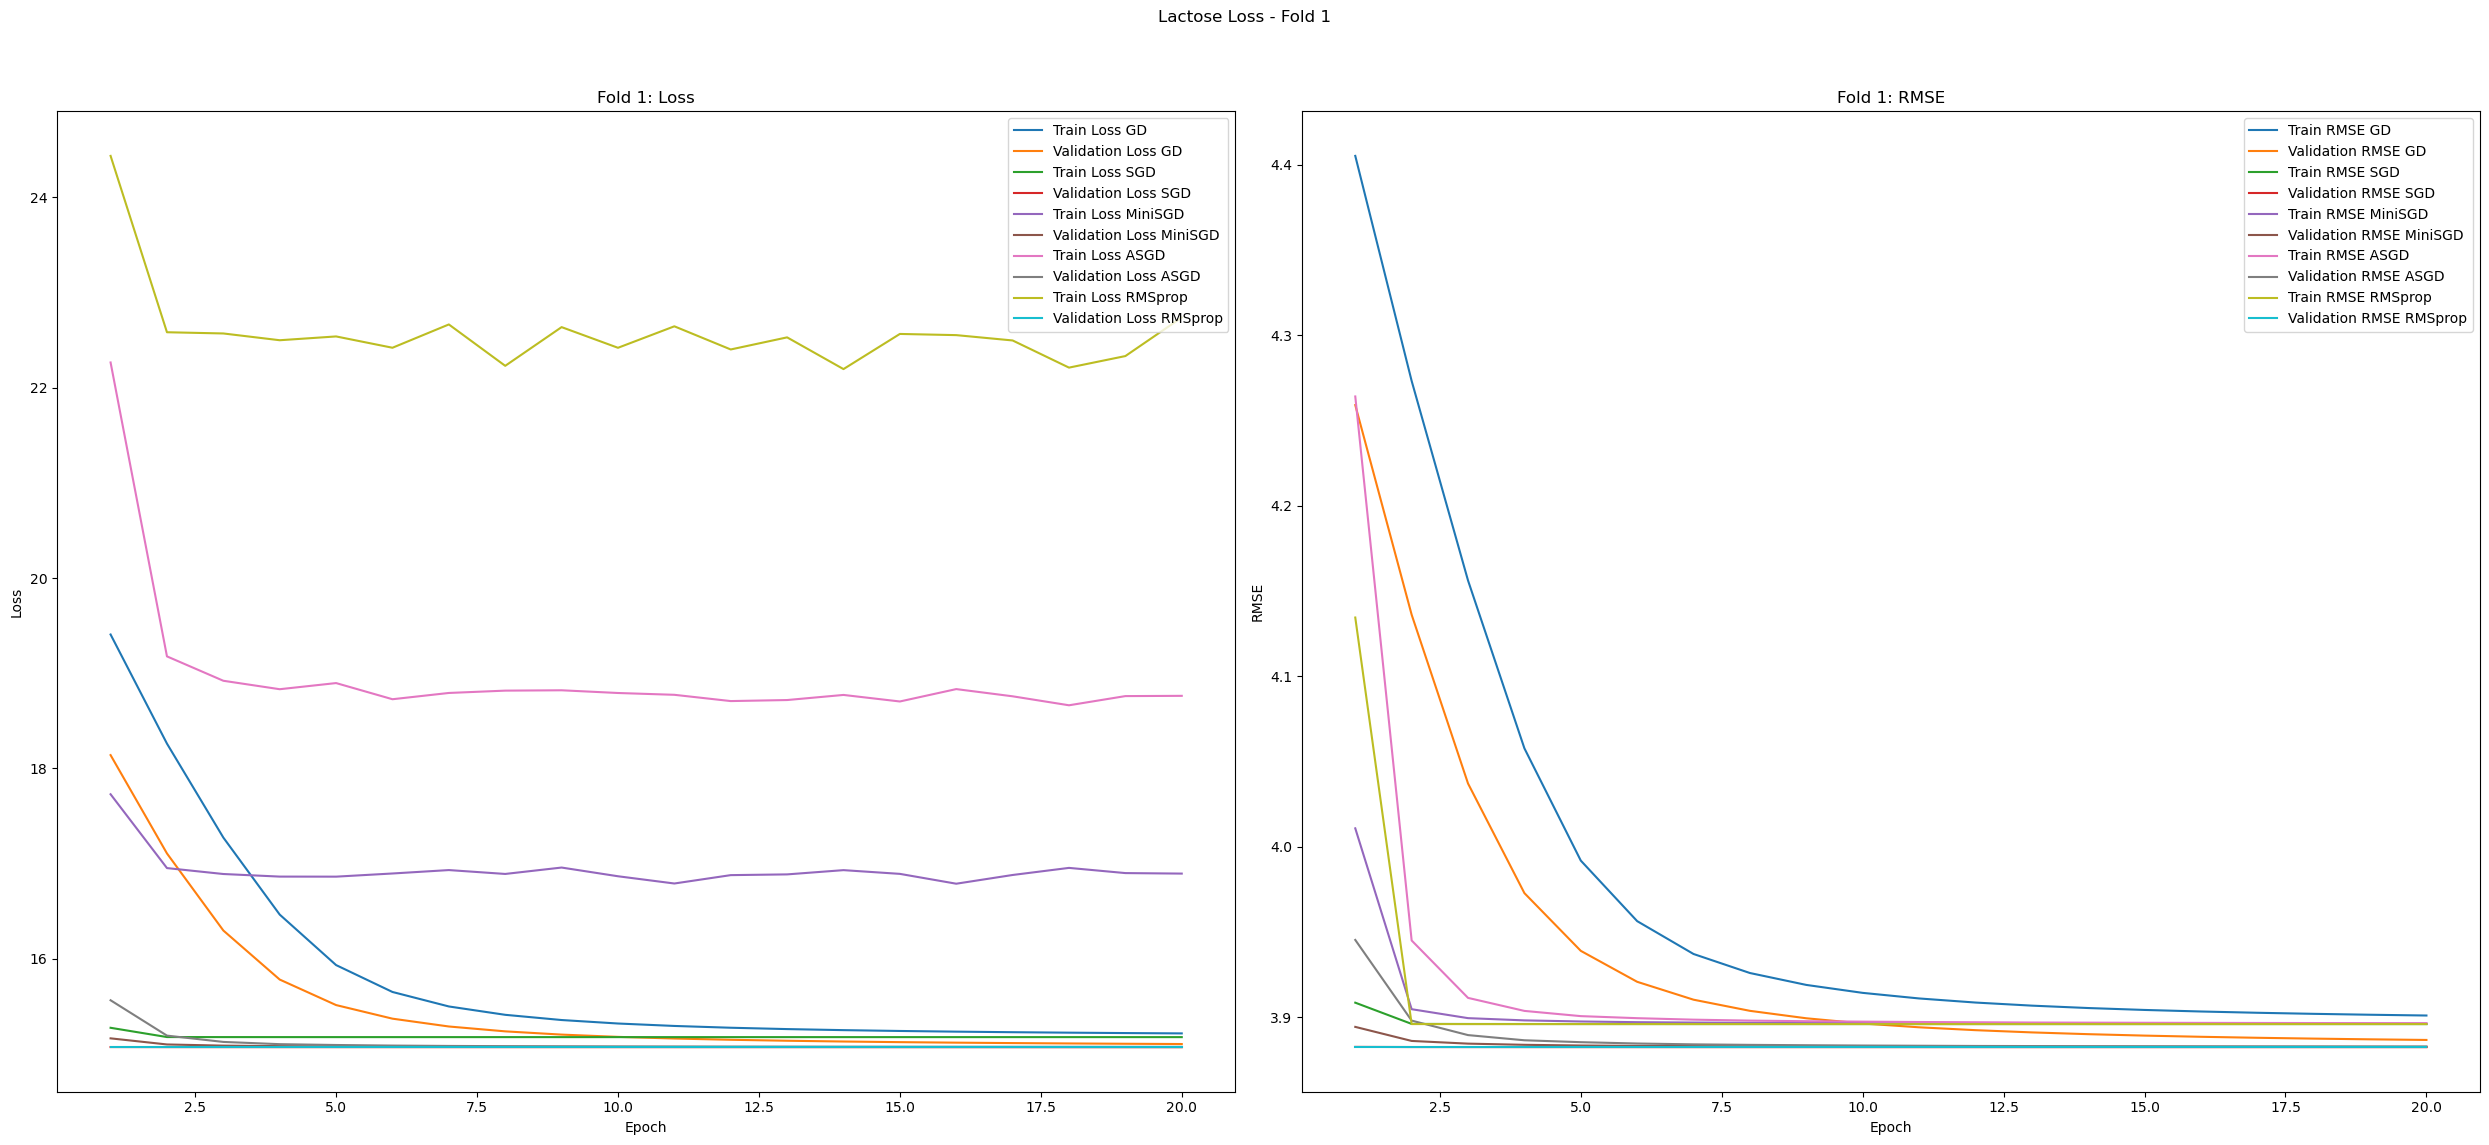

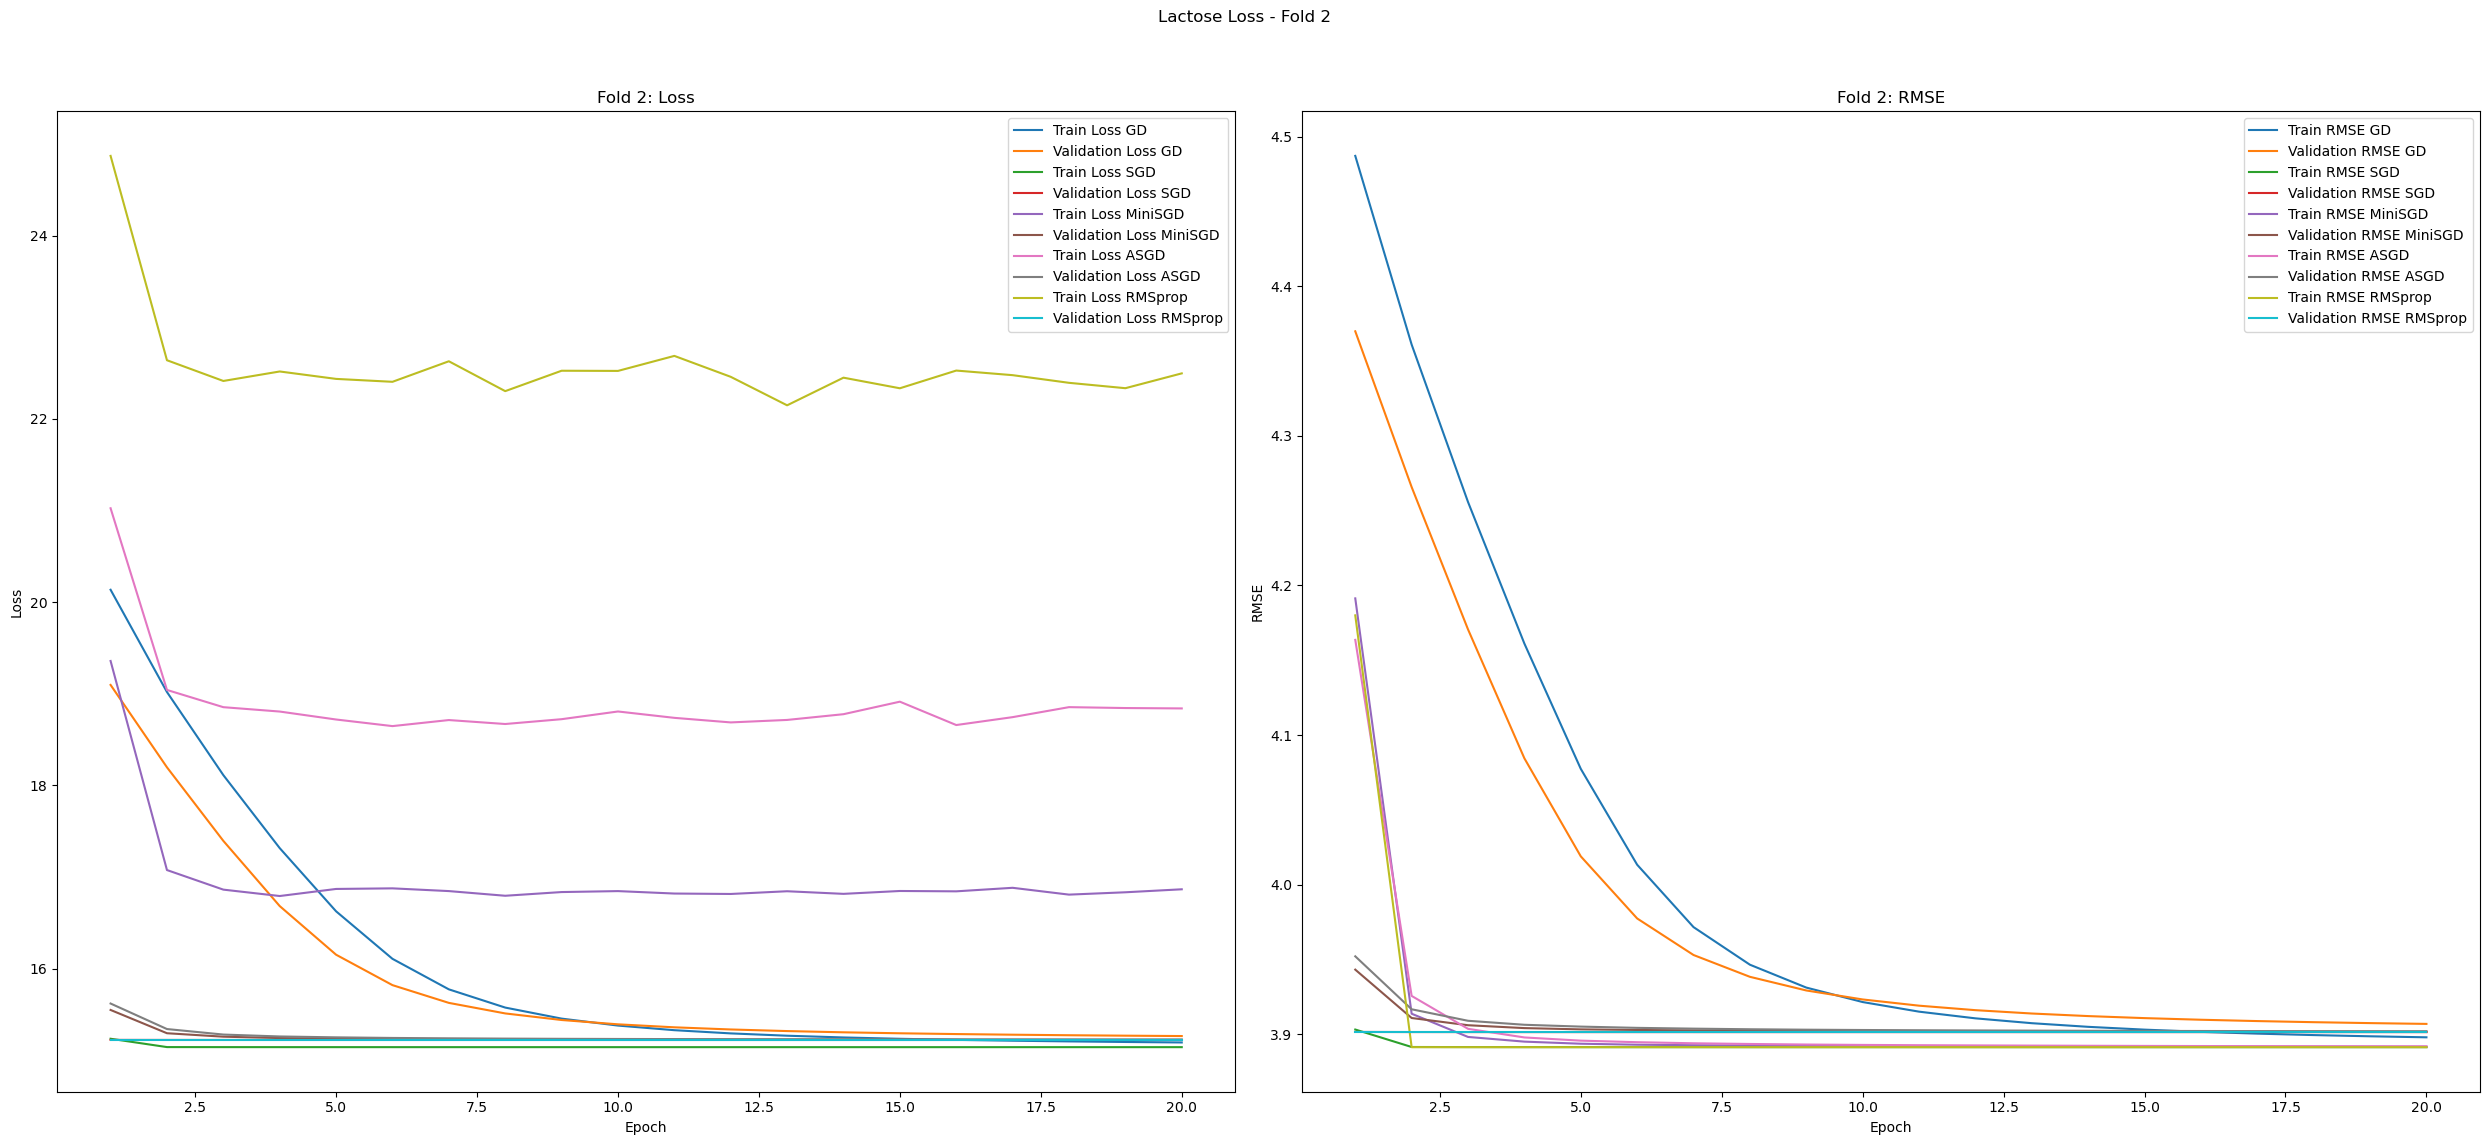

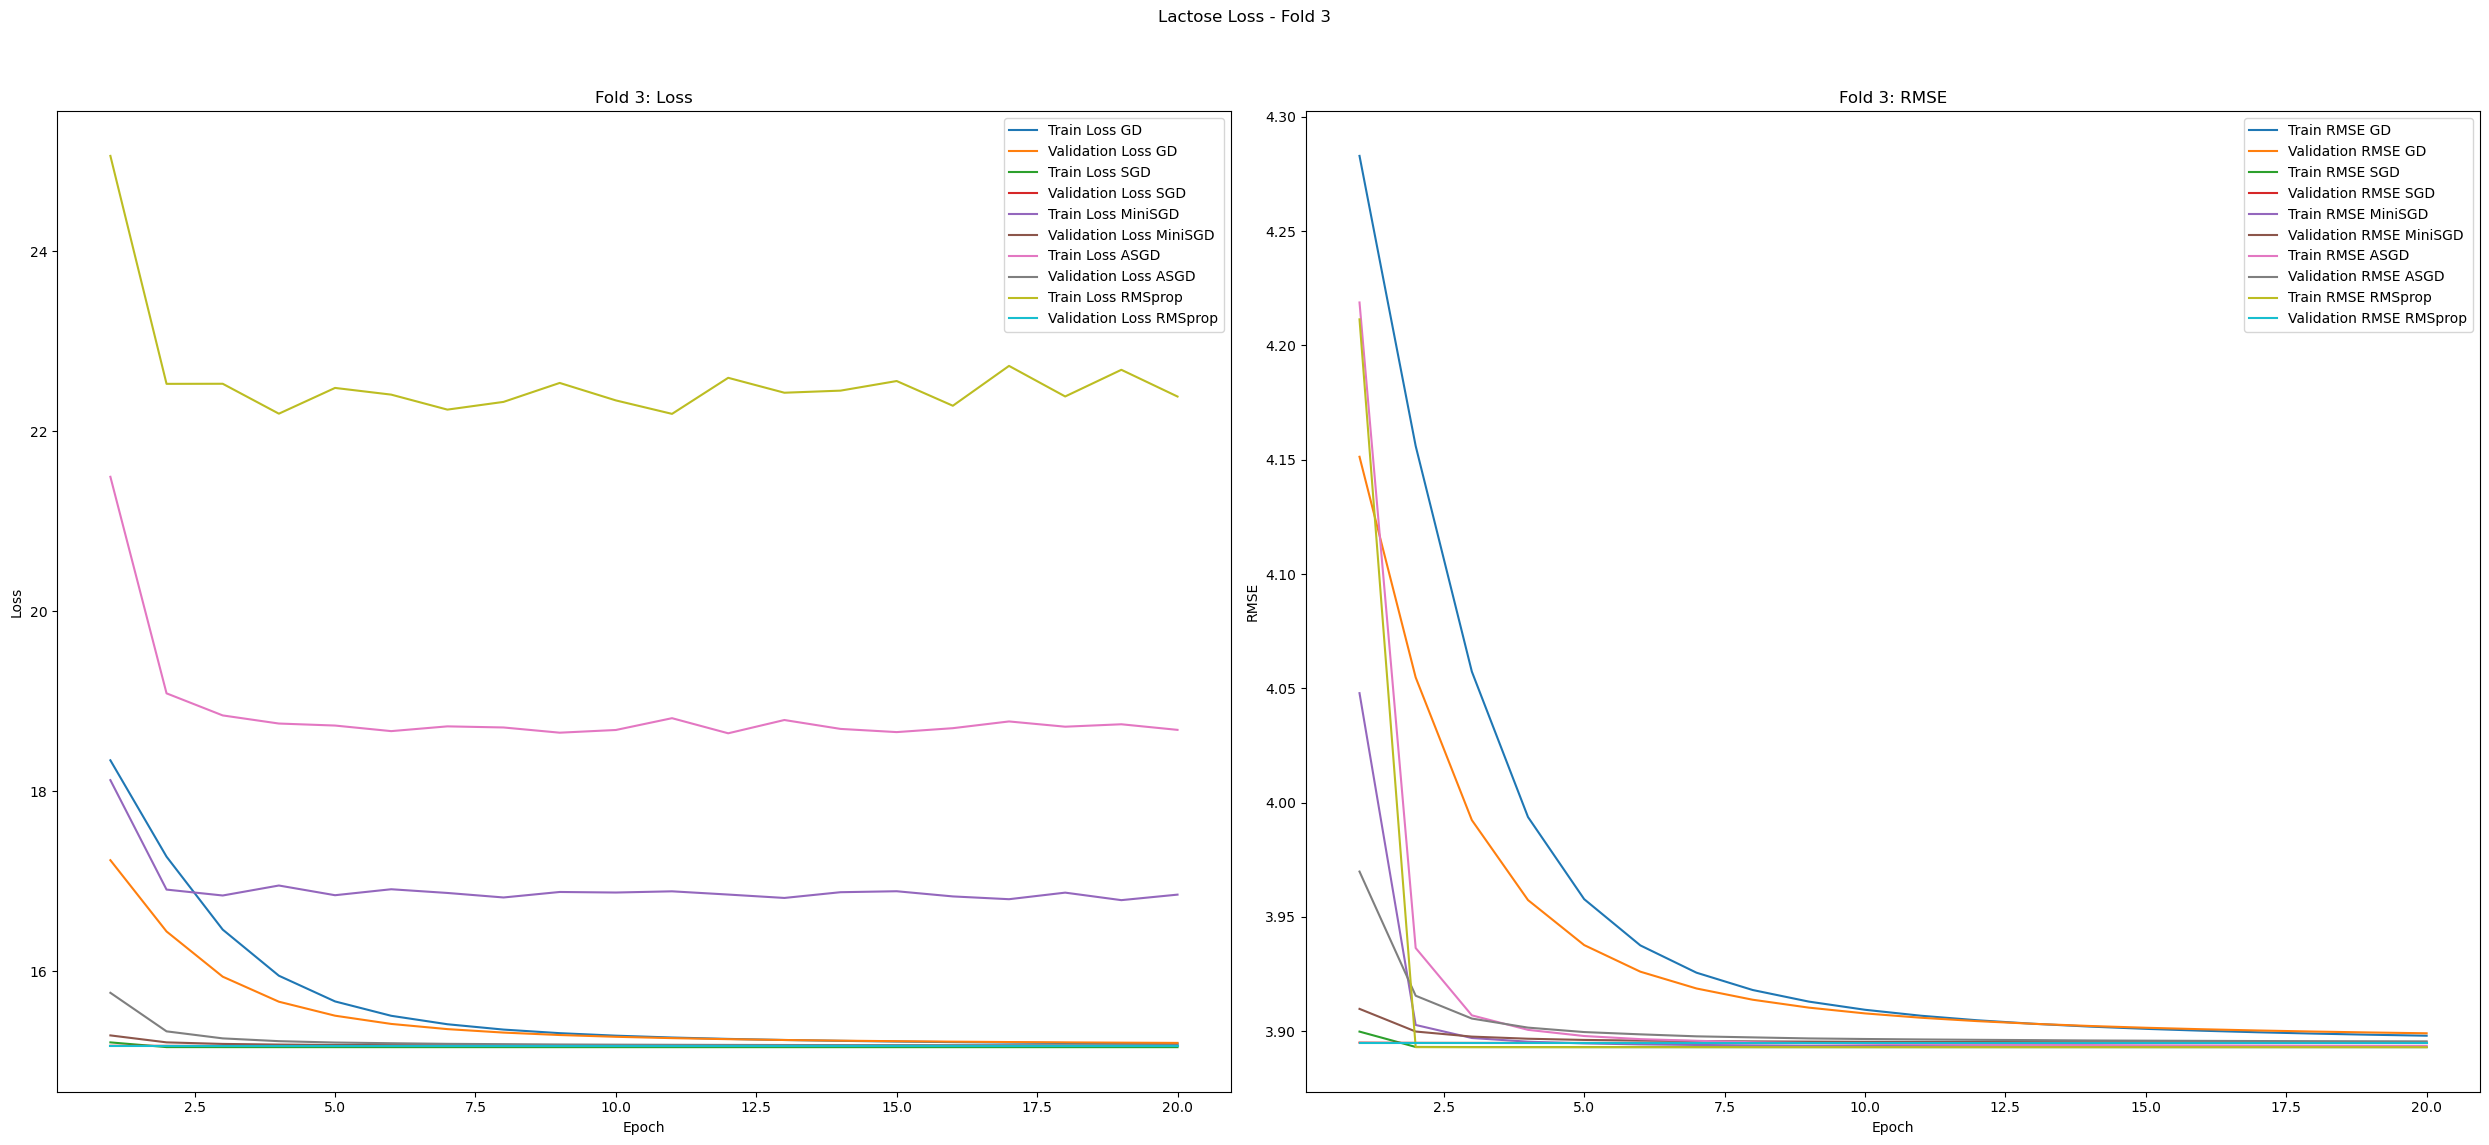

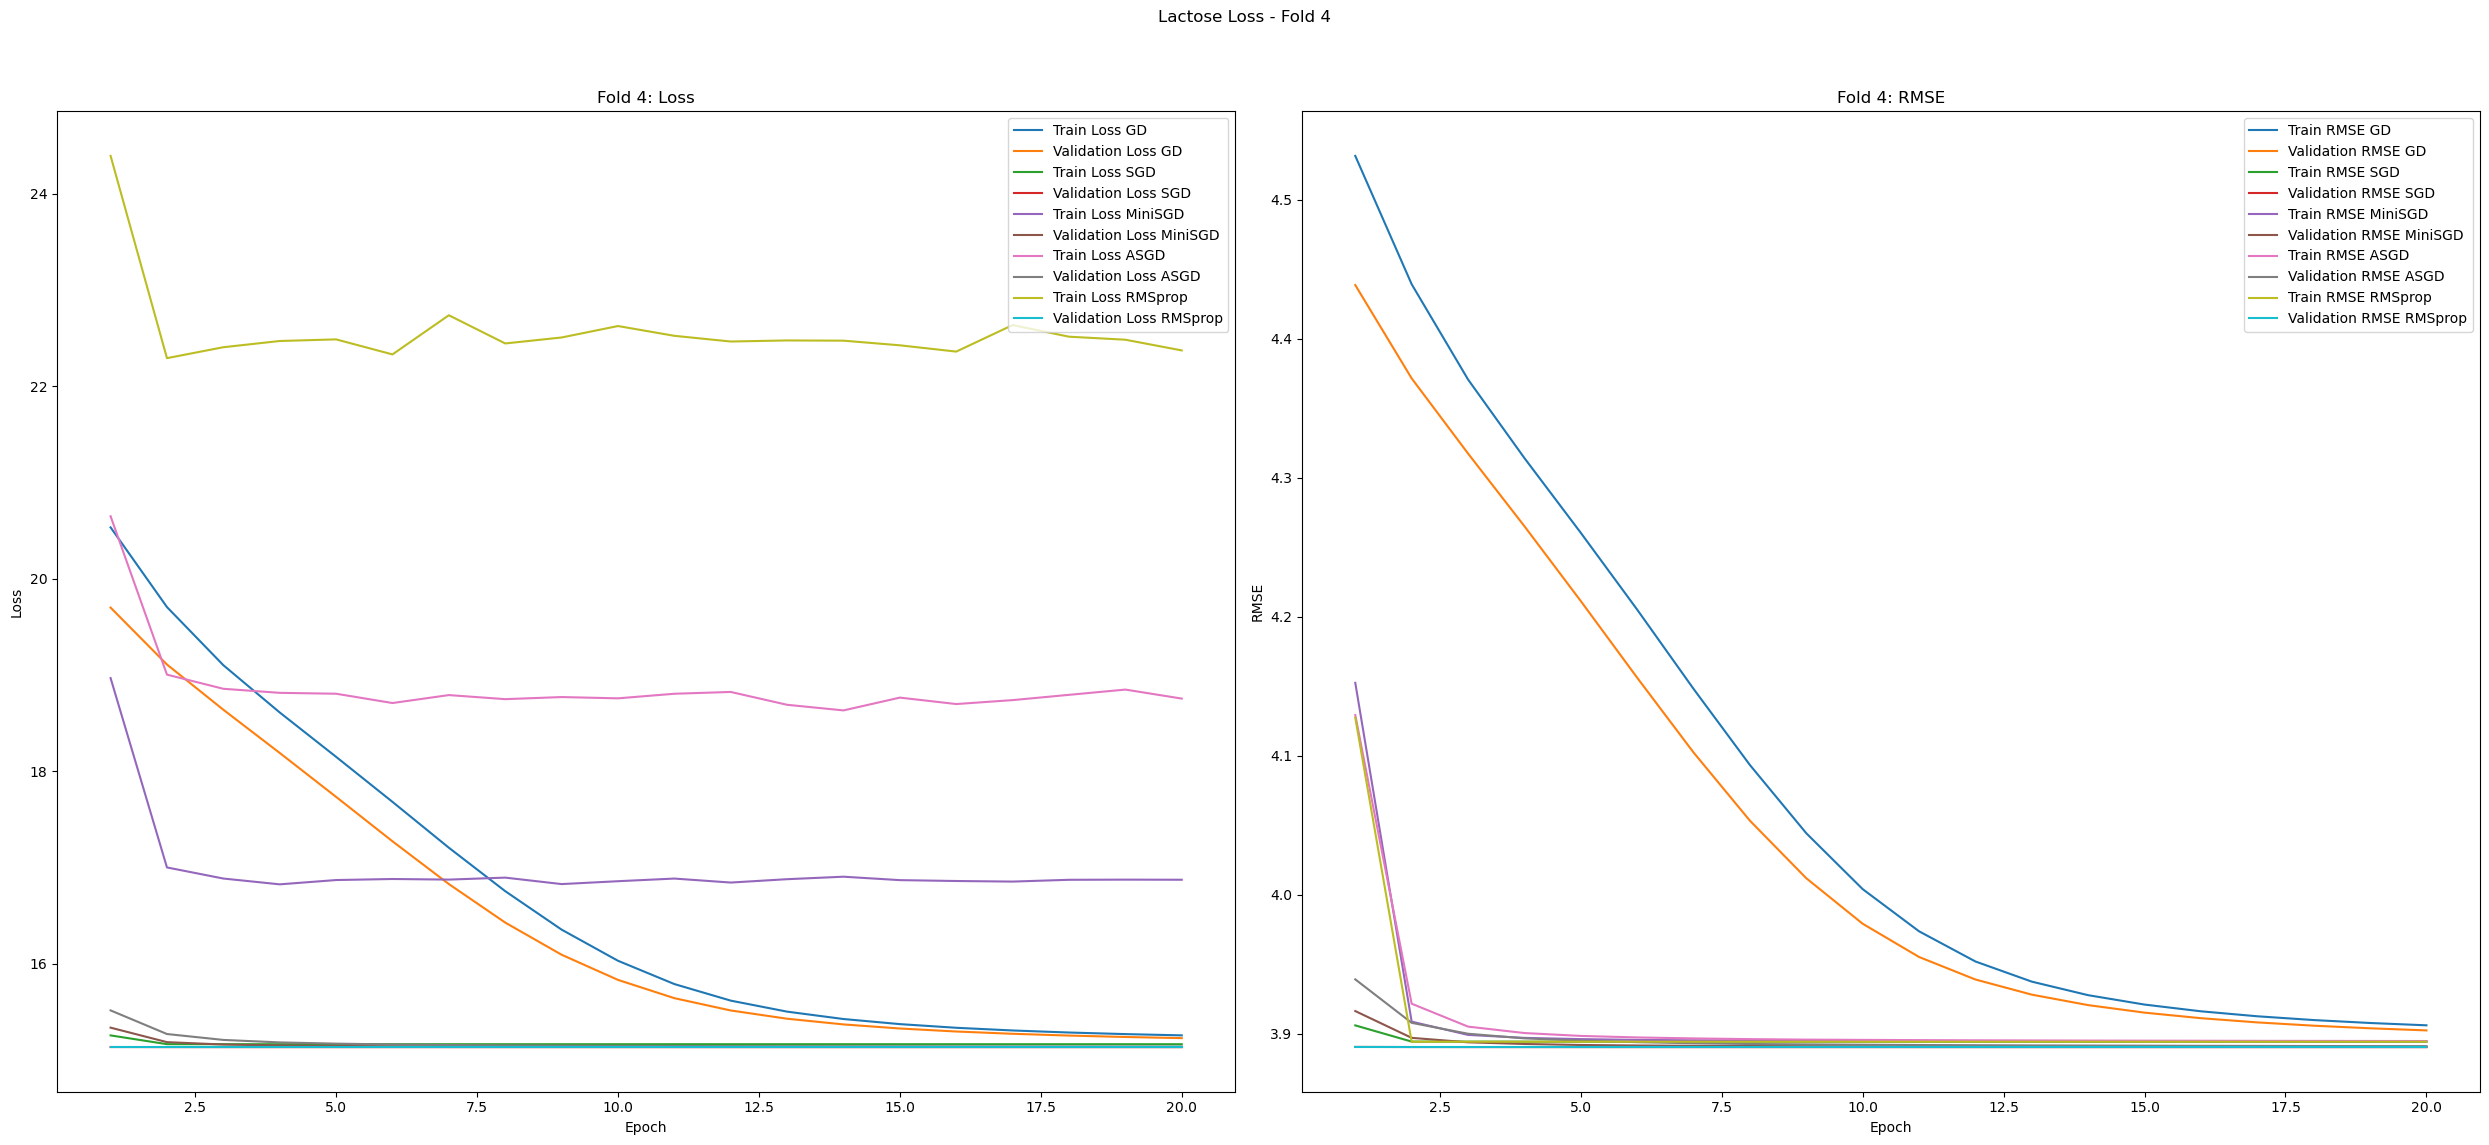

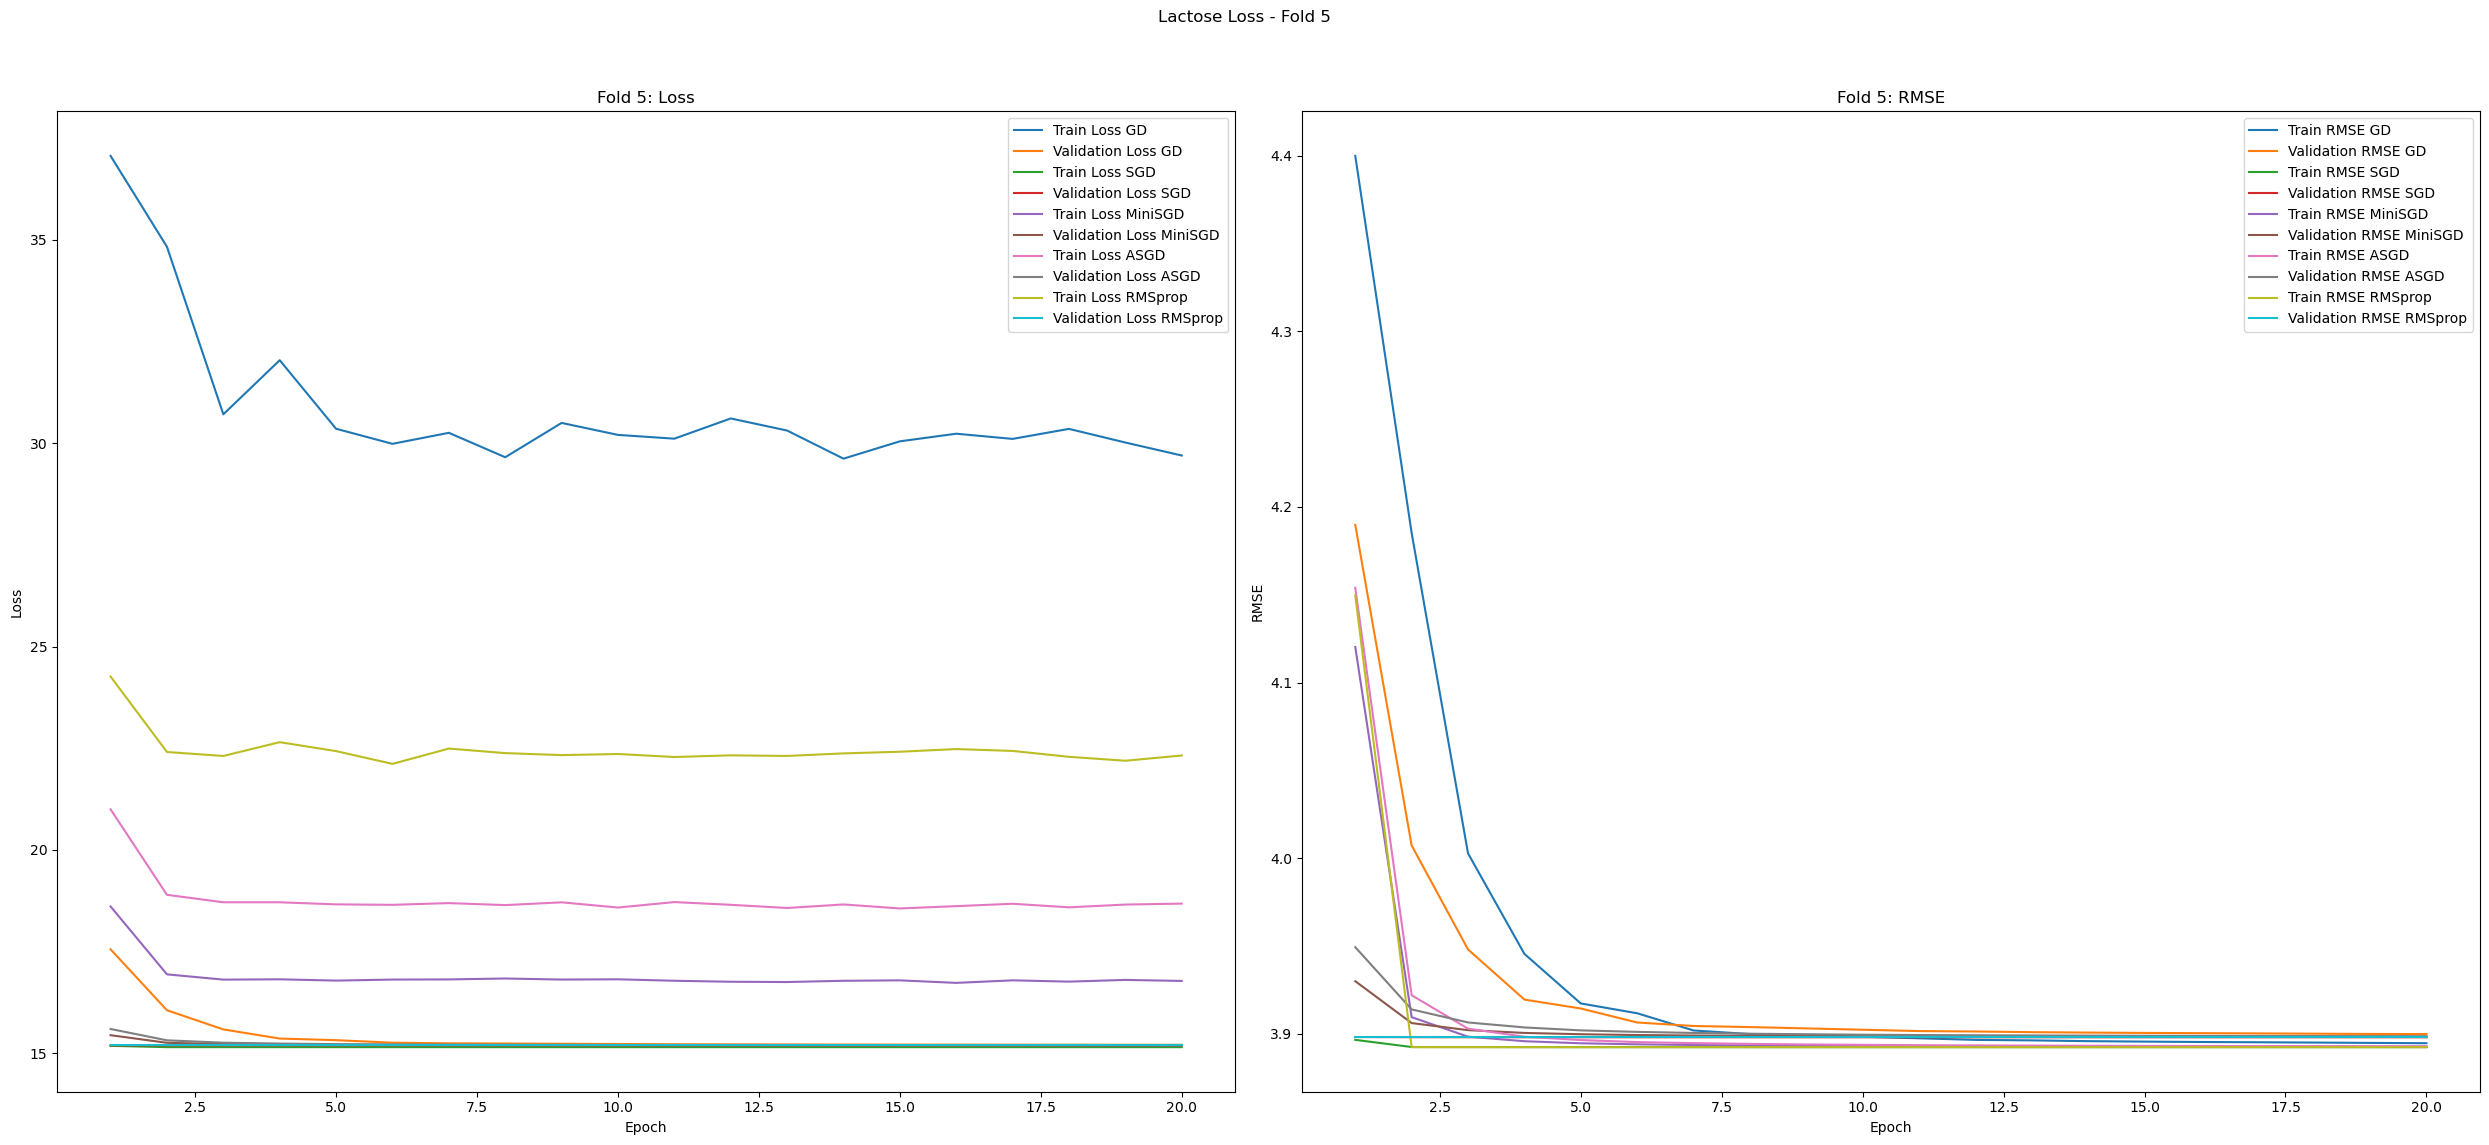

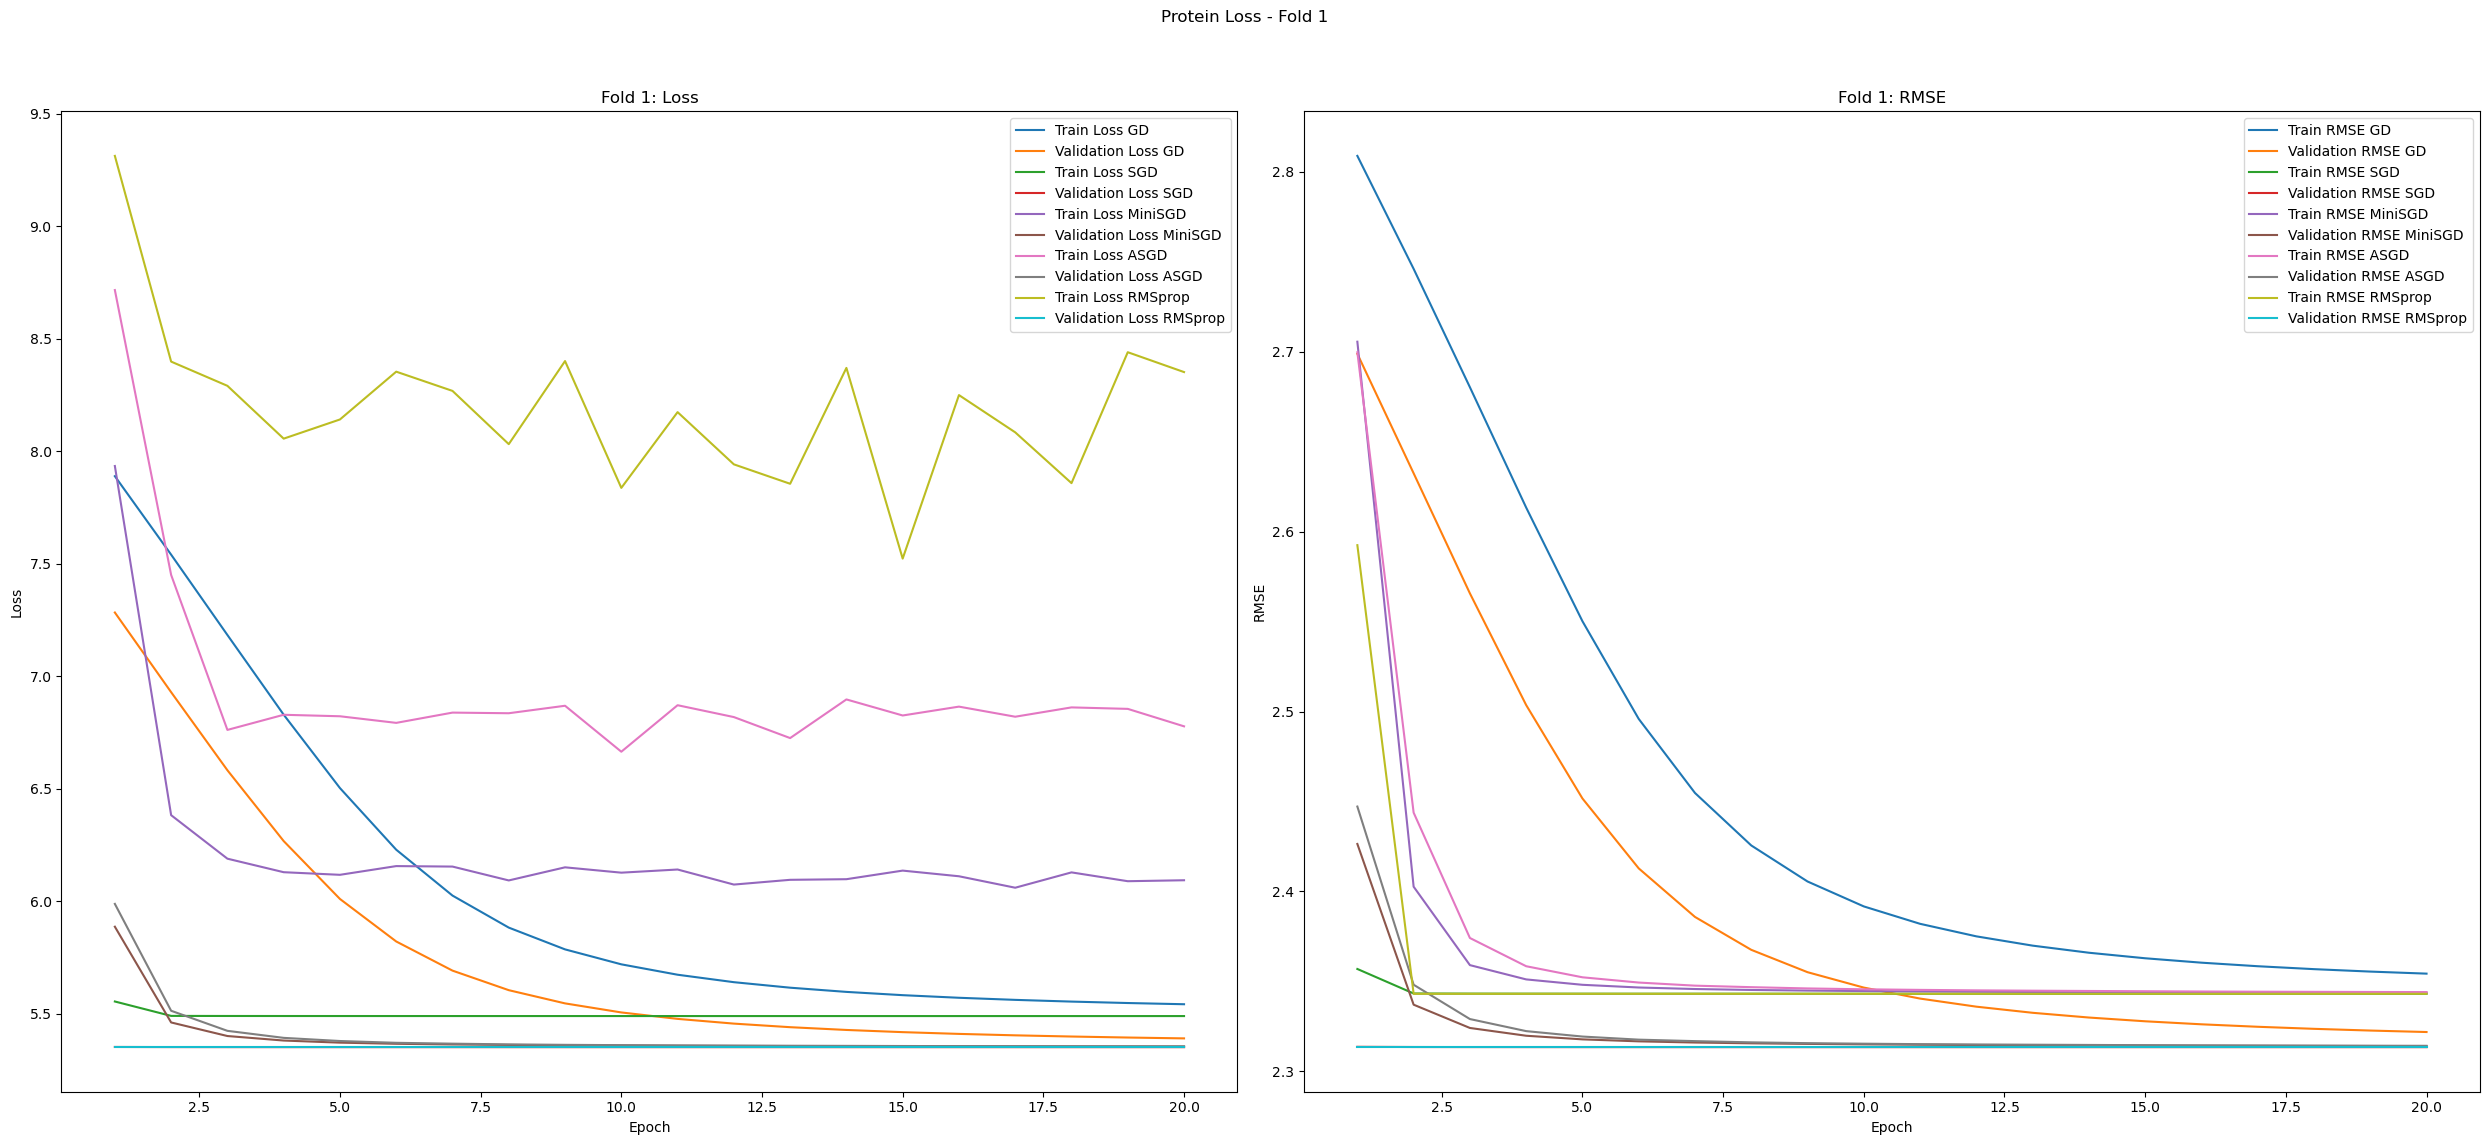

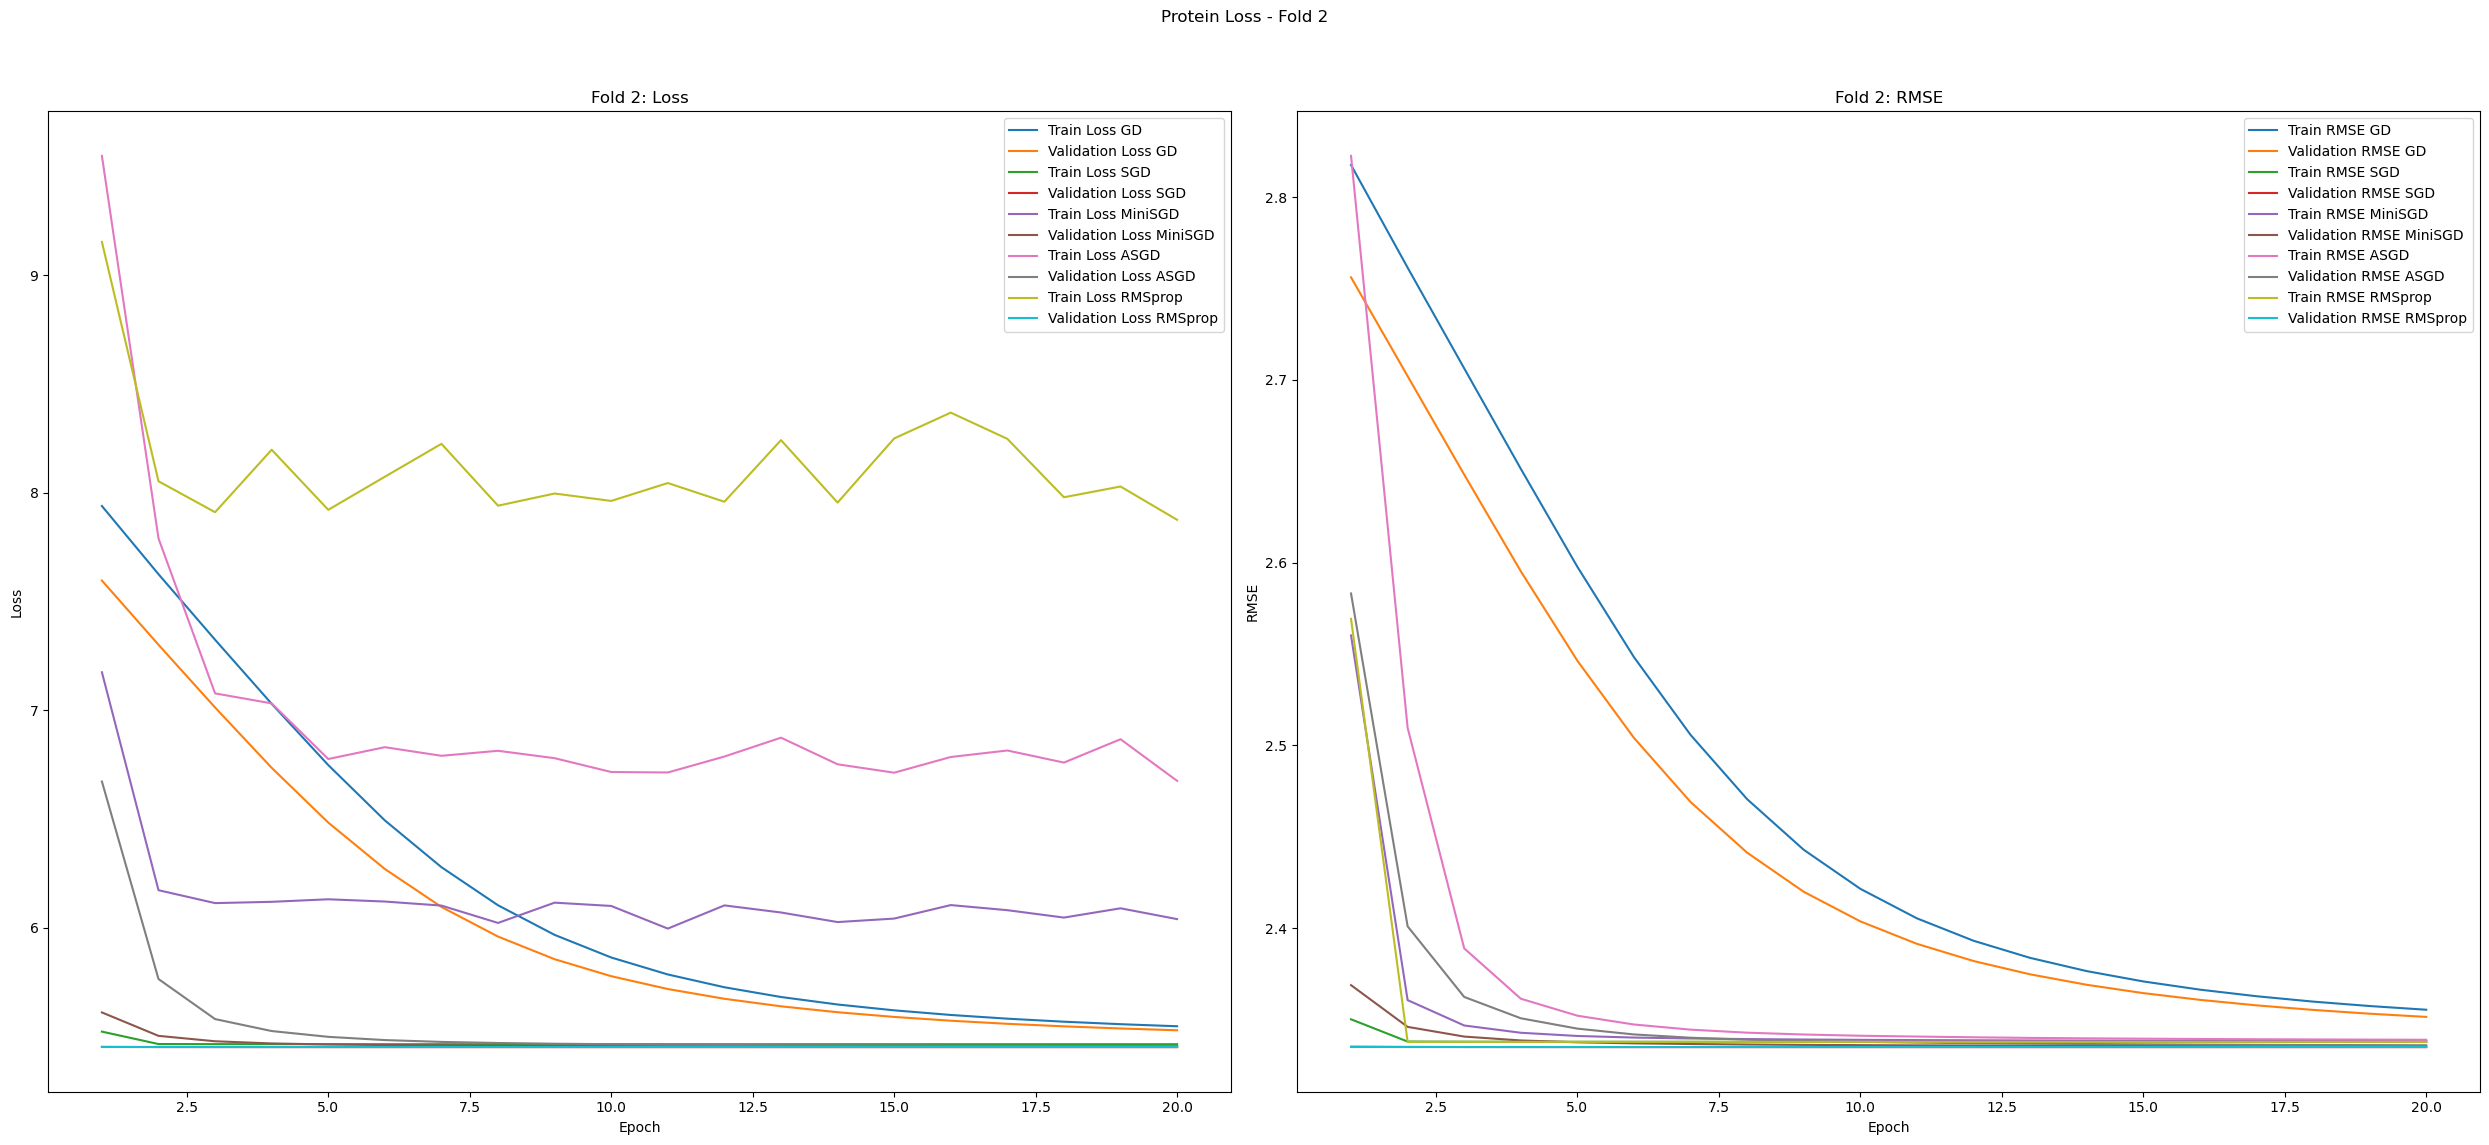

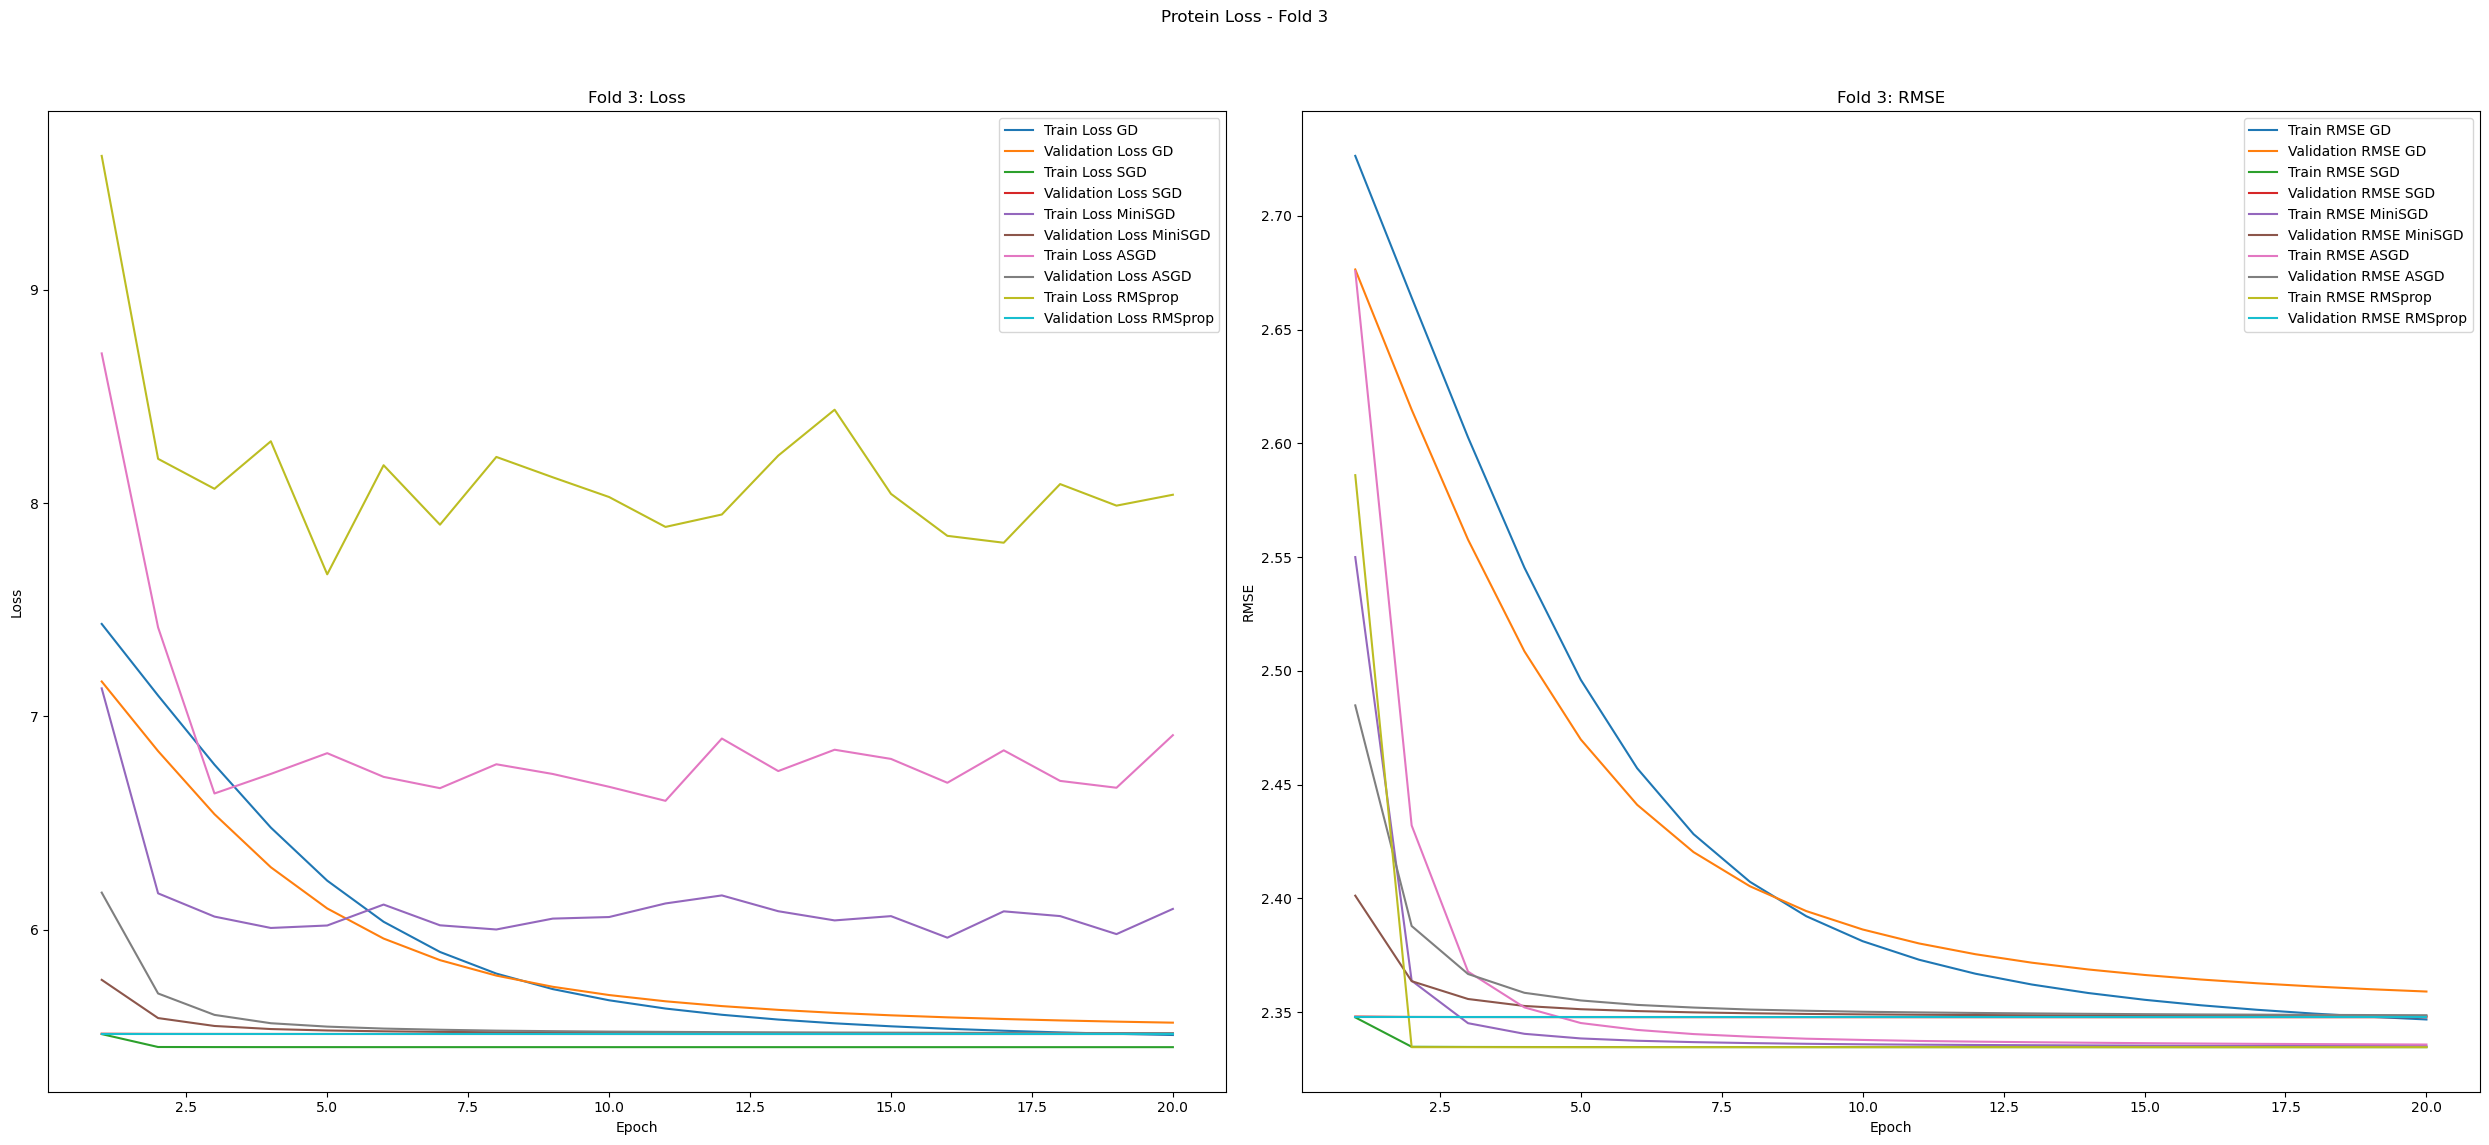

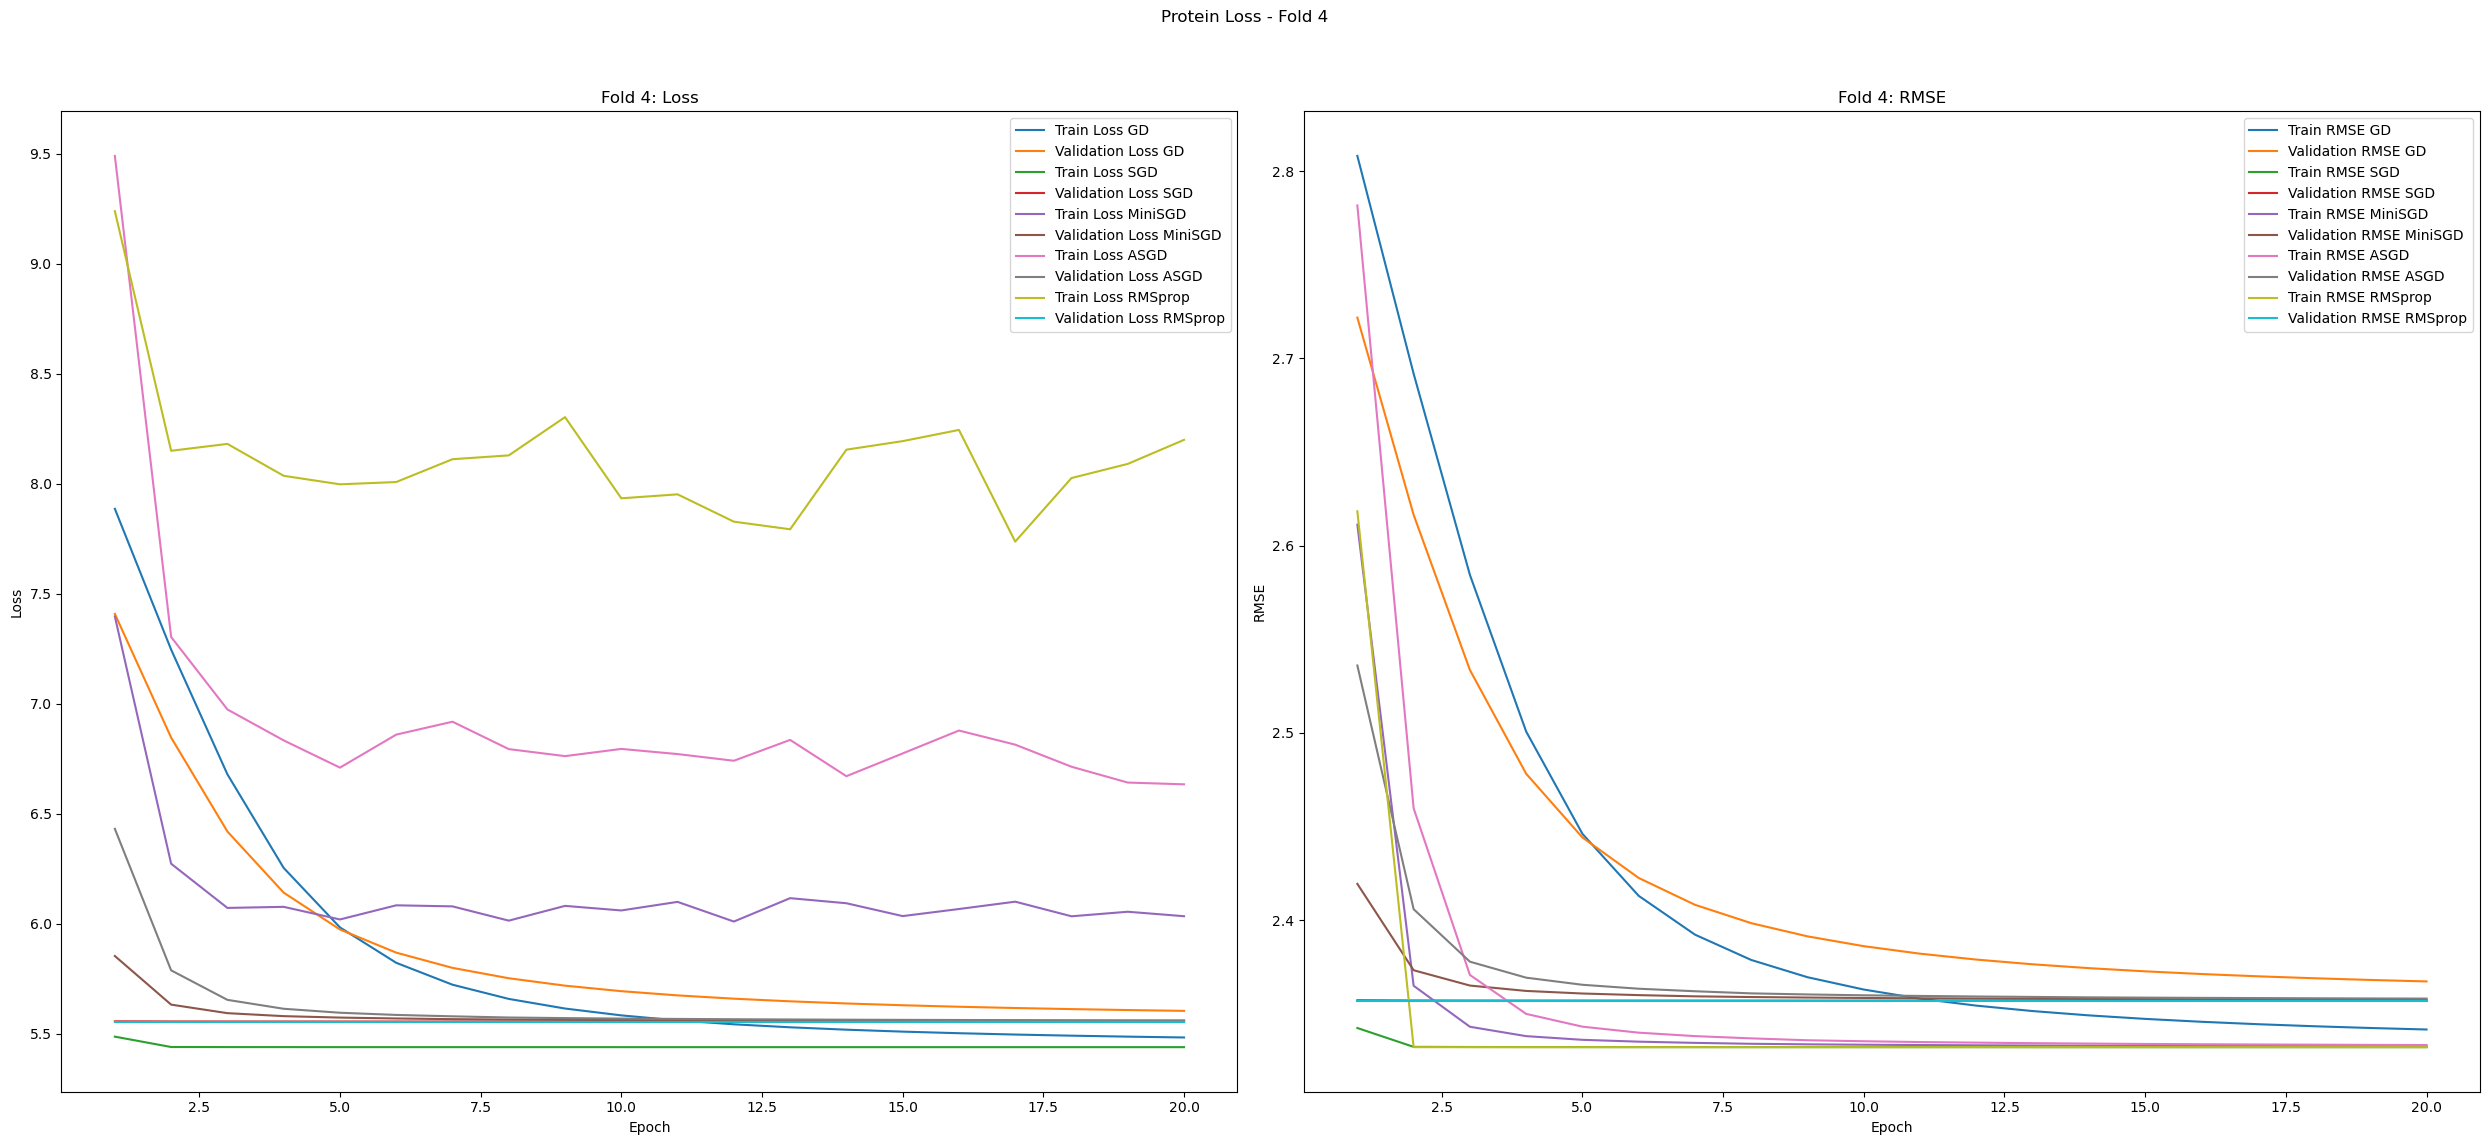

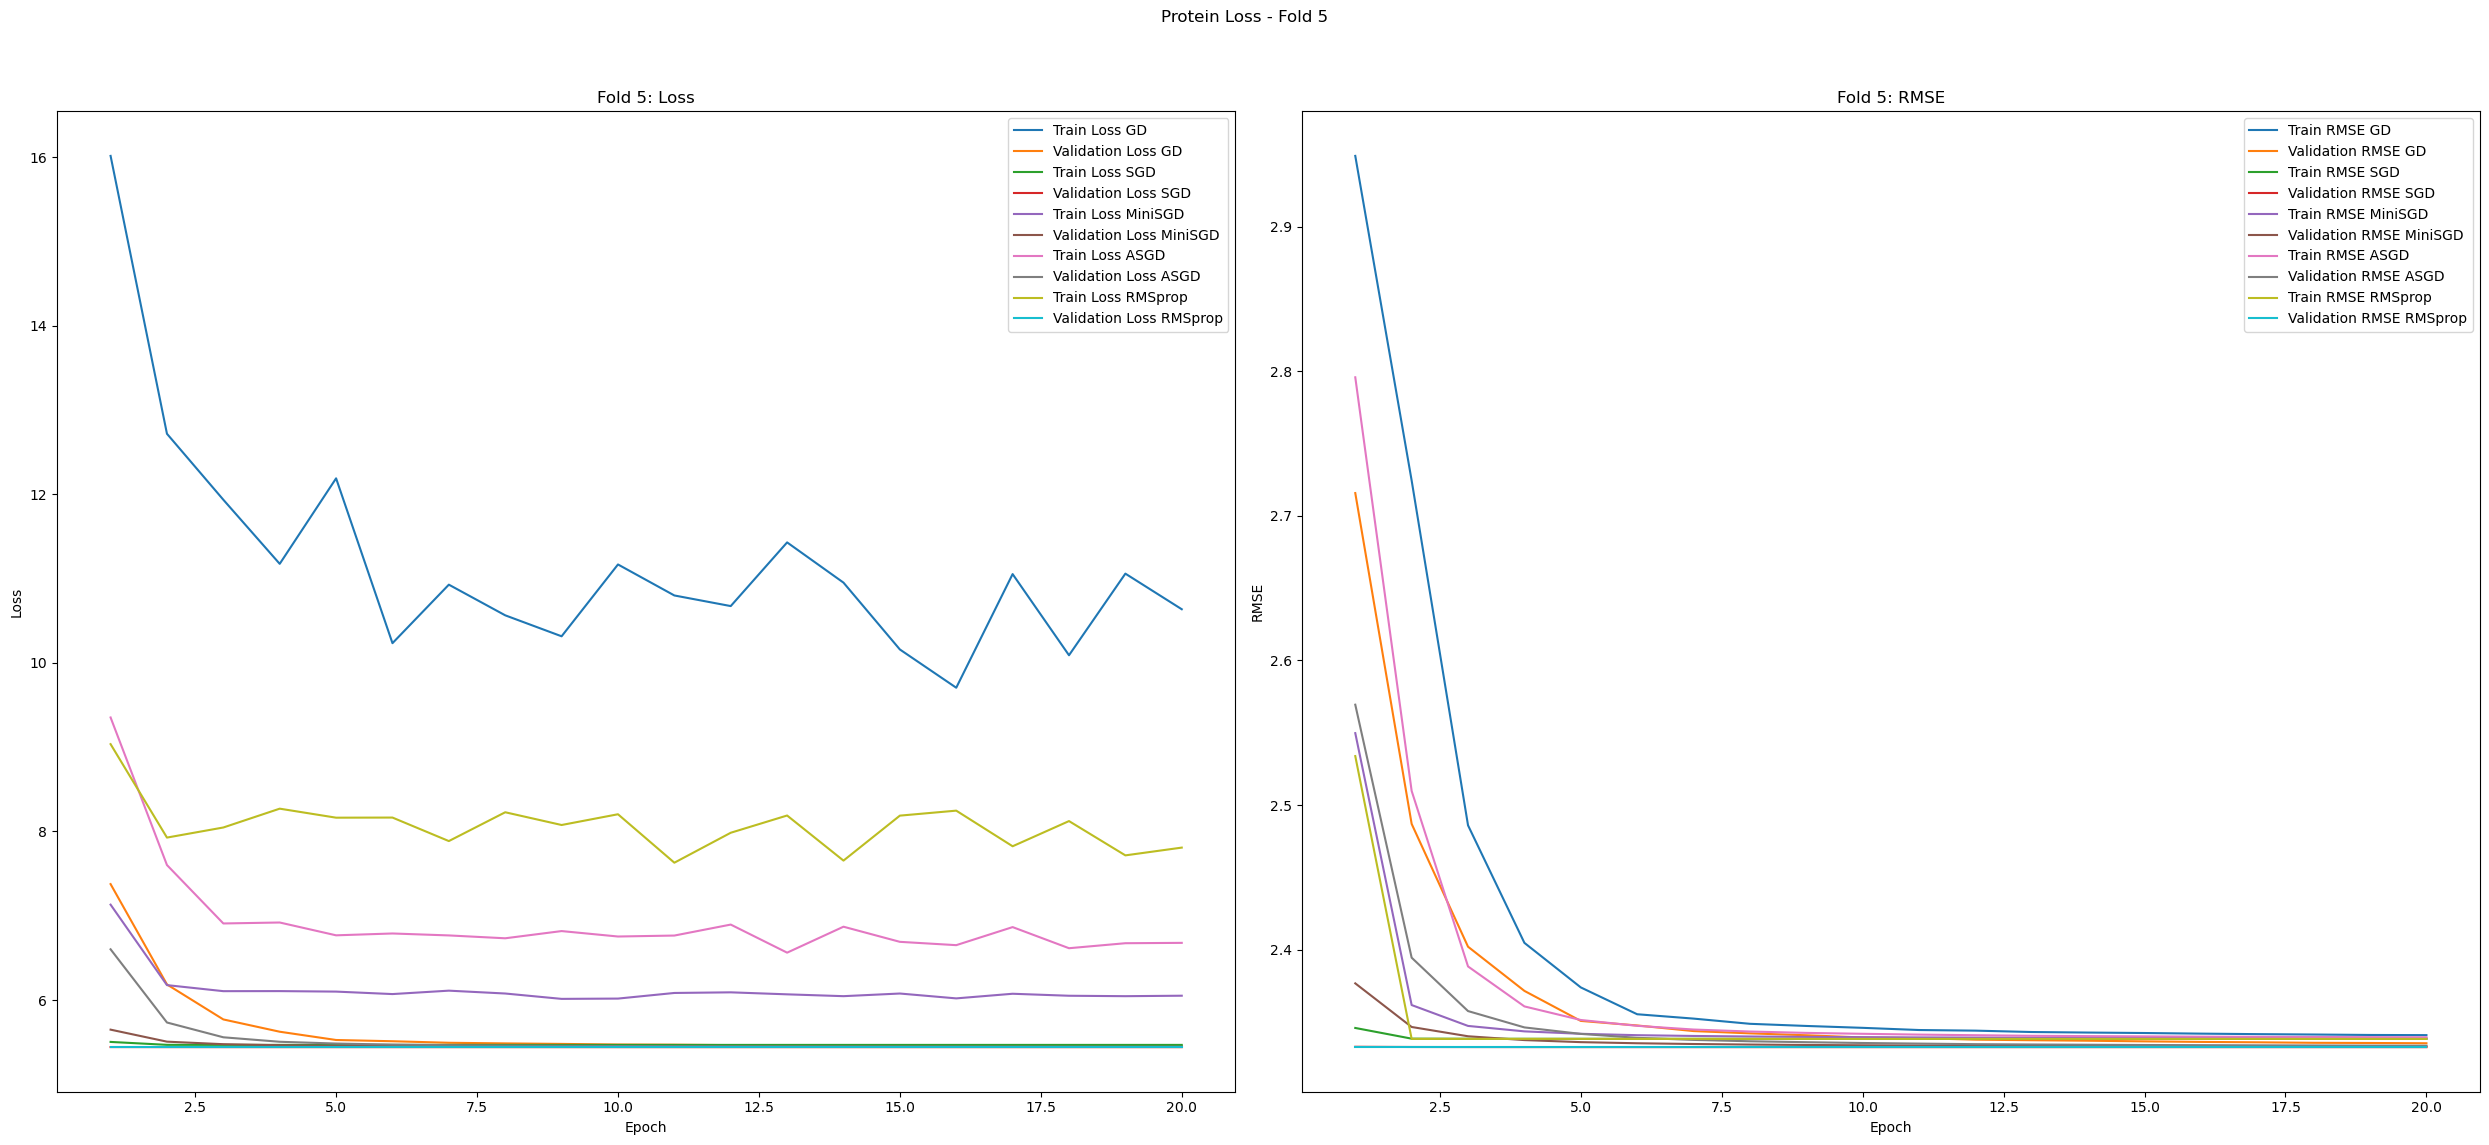

In [25]:
def plot_history(history, title):
    num_folds = len(history.values())
    for fold in range(1, num_folds + 1):
        fig, axs = plt.subplots(1, 2, figsize=(25, 12)) 

        for nn_name, history_nn in history.items():
            metrics = history_nn[f'Fold_{fold}']
            
            axs[0].plot(range(1, len(metrics[0]) + 1), metrics[0], label=f'Train Loss {nn_name}')
            axs[0].plot(range(1, len(metrics[1]) + 1), metrics[1], label=f'Validation Loss {nn_name}')
            axs[0].set_title(f'Fold {fold}: Loss')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].legend()

            axs[1].plot(range(1, len(metrics[2]) + 1), metrics[2], label=f'Train RMSE {nn_name}')
            axs[1].plot(range(1, len(metrics[3]) + 1), metrics[3], label=f'Validation RMSE {nn_name}')
            axs[1].set_title(f'Fold {fold}: RMSE')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('RMSE')
            axs[1].legend()

        plt.suptitle(f'{title} - Fold {fold}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Call the function to plot the history
plot_history(history_kfold_fat, 'Fat Loss')
plot_history(history_kfold_lactose, 'Lactose Loss')
plot_history(history_kfold_protein, 'Protein Loss')


In [ ]:
device = 'cpu'
temp_config_path = "temp_config_feedforward_xor"

def fitness_function(genomes, config, inputs, expected_outputs):
    # Convert inputs and expected_outputs to lists if they are tensors
    inputs_list = inputs.tolist() if isinstance(inputs, torch.Tensor) else inputs
    outputs_list = expected_outputs.tolist() if isinstance(expected_outputs, torch.Tensor) else expected_outputs
    
    # Iterate over genomes and calculate fitness
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = 0.0
        for xi, xo in zip(inputs_list, outputs_list):
            output = net.activate(xi)
            genome.fitness -= float((output[0] - xo) ** 2) 

class StdOutReporter(neat.reporting.BaseReporter):
    def post_evaluate(self, config, population, species, best_genome):
        fit_mean = np.mean([g.fitness for g in population.values()])
        fit_std = np.std([g.fitness for g in population.values()])

        best_species_id = species.get_species_id(best_genome.key)
        best_fitness = float(best_genome.fitness)
        print('Population\'s average fitness: {0:3.5f} stdev: {1:3.5f}'.format(fit_mean, fit_std))
        print('Best fitness: {0:3.5f} - size: {1!r} - species {2} - id {3}'.format(best_fitness,
                                                                                     best_genome.size(),
                                                                                     best_species_id,
                                                                                     best_genome.key))

# Function to run NEAT for a given target
def run_neat_for_target(inputs, outputs, config):
    pop = neat.Population(config)
    pop.add_reporter(neat.StdOutReporter(True))
    pop.add_reporter(StdOutReporter())
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)

    # Pass inputs and outputs as iterable objects
    pop.run(lambda genomes, config: fitness_function(genomes, config, inputs, outputs), 300)

    winner = pop.best_genome
    return winner

# Load configuration
config_path = "config-feedforward-xor"  # Ensure this file exists in your working directory

# Read the configuration file with UTF-8 encoding
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    content = f.read()

# Write content to a temporary file with UTF-8 encoding
with codecs.open(temp_config_path, 'w', encoding='utf-8') as f:
    f.write(content)
    
# Load configuration using the temporary file
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation,
                            temp_config_path)

# Assuming X_train_folds, y_fat_train_folds, etc. are defined elsewhere
for fold_idx in range(len(X_train_kf)):
    X_train_fold = X_train_kf[fold_idx]
    y_fat_train_fold = y_fat_train_kf[fold_idx]
    y_lactose_train_fold = y_lactose_train_kf[fold_idx]
    y_protein_train_fold = y_protein_train_kf[fold_idx]

    # Convert data to numpy arrays
    X_train_fold_np = X_train_fold.cpu().numpy()
    y_fat_train_fold_np = y_fat_train_fold.cpu().numpy()
    y_lactose_train_fold_np = y_lactose_train_fold.cpu().numpy()
    y_protein_train_fold_np = y_protein_train_fold.cpu().numpy()
    # Train NEAT models for each target
    target = {
        'lactose': run_neat_for_target(X_train_fold_np, y_lactose_train_fold_np, config),
        'fat': run_neat_for_target(X_train_fold_np, y_fat_train_fold_np, config),
        'protein': run_neat_for_target(X_train_fold_np, y_protein_train_fold_np, config)
    }



 ****** Running generation 0 ****** 

Population's average fitness: -6208.44113 stdev: 0.00000
Best fitness: -6208.44113 - size: (1, 0) - species 1 - id 1
Population's average fitness: -6208.44113 stdev: 0.00000
Best fitness: -6208.44113 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.567, standard deviation 1.665
Population of 100 members in 3 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0    91  -6208.441    0.000     0
     2    0     7  -6208.441    0.000     0
     3    0     2         --       --     0
Total extinctions: 0
Generation time: 0.071 sec

 ****** Running generation 1 ****** 

Population's average fitness: -6109.84428 stdev: 392.76498
Best fitness: -3932.13752 - size: (1, 1) - species 2 - id 111
Population's average fitness: -6109.84428 stdev: 392.76498
Best fitness: -3932.13752 - size: (1, 1) - species 2 - id 111
Average adjusted fitness: 0.102
Mean genetic distanc

/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_95185/3008893747.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  genome.fitness -= float((output[0] - xo) ** 2)


Population's average fitness: -4593.41798 stdev: 1430.98588
Best fitness: -286.07938 - size: (1, 1) - species 5 - id 267
Population's average fitness: -4593.41798 stdev: 1430.98588
Best fitness: -286.07938 - size: (1, 1) - species 5 - id 267
Average adjusted fitness: 0.363
Mean genetic distance 3.866, standard deviation 1.875
Population of 99 members in 5 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    2    29  -3405.161    0.128     0
     2    2    14  -3931.529    0.376     0
     3    2     5  -4831.234    0.019     0
     4    1    25  -1307.120    0.455     0
     5    1    26   -286.079    0.835     0
Total extinctions: 0
Generation time: 0.098 sec (0.082 average)

 ****** Running generation 3 ****** 

Population's average fitness: -3107.06399 stdev: 2048.24809
Best fitness: -85.00091 - size: (2, 2) - species 4 - id 355
Population's average fitness: -3107.06399 stdev: 2048.24809
Best fitness: -85.00091 - size: (2, 2) - s

## GSGP 

In [1]:
for i in range(0, len(X_train_kf)):
    batch_size = len(X_train_kf[i])
    ds_train_kf = TensorDataset(X_train_kf[i], y_lactose_train_kf[i])
    ds_val_kf = TensorDataset(X_val_kf[i], y_lactose_val_kf[i])
    dl_train_1  =DataLoader(ds_train_kf, batch_size, shuffle)
    dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
    sspace_sml_gs = {
        'n_dims': X_train_kf[i].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device,
        'n_batches': 1
    }
    pi_sml = SML(
    sspace=sspace_sml_gs,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train_1, dl_test=dl_val_1
)
    ps = batch_size
    selection_pressure = .07
    mutation_prob = .1
    xo_prob = .9
    seed = 1
    has_elitism = True
    allow_reproduction = False
    to, by = 5.0, 0.25
    ms = torch.arange(by, to + by, by, device=device)

    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=prm_tournament(pressure=selection_pressure),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        #
        # Notice that, in GPOL-based implementation that we are using, 
        # these operators are the only settings that 
        # are necessary to define a Geometric Semantic GP.
        #
        crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
        mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
)
    mheuristic._initialize()
    print(mheuristic.pop)
    print('------------------------')
    print(mheuristic.best_sol.fit)
    print(mheuristic.best_sol.printTree())
    print('------------------------')

NameError: name 'X_train_kf' is not defined

## GSGP EFFICIENT

In [ ]:
for i in range(0, len(X_train_kf)):
    batch_size = len(X_train_kf[i])

    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['exp'],
                function_map['log']]
    train_indices = []
    val_indices = []
    for j in range(0, len(X_train_kf[i])):
        train_indices.append(j)
        val_indices.append(j)
    train_index = torch.tensor(train_indices)
    val_index = torch.tensor(val_indices)

    sspace_sml_gs = {
        'n_dims': X_train_kf[i].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device
    }
    print(i)
    pi_sml_gs = SMLGS(
        sspace=sspace_sml_gs,
        ffunction=Ffunctions('rmse'),
        X=X_train_kf[i], y=y_lactose_train_kf[i],
        train_indices=train_index,
        test_indices=val_index
    )

    ps = batch_size
    # ps = 250
    selection_pressure = .07
    mutation_prob = .7
    xo_prob = .3
    has_elitism = True
    allow_reproduction = False

    mheuristic = GSGP(
        pi=pi_sml_gs,
        #
        # If individuals should be reconstructed, it must be defined before fitting the algorithm.
        #
        path_init_pop=path_init_pop, 
        path_rts=path_rts, 
        #
        # Initializer - it can be the same tree initializer as traditional GP.
        #
        initializer=grow,
        #
        # Selector - it can be the same GP selector as tradicional GP.
        #
        selector=prm_tournament(pressure=selection_pressure),
        #
        # Other Algorithm hyperparameters
        #
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        #
        # Efficient Crossover
        #
        crossover=prm_efficient_gs_xo(X_train_kf[0], prm_grow(sspace=pi_sml_gs.sspace)),
        #
        # Efficient Mutation
        #
        mutator=prm_efficient_gs_mtn(X_val_kf[0], prm_grow(sspace=pi_sml_gs.sspace), ms)
    )
    mheuristic._initialize()
    print("---------------------")
    print(mheuristic.best_sol.fit)
    print(mheuristic.best_sol.repr_)
    print(mheuristic.pi.y.shape)
    print(mheuristic.best_sol.repr_.shape)
    print("---------------------")